In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 

from vehicle_model_variant import Environment 
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_nimh_6_240_panasonic_MY01_Prius.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
# env = Environment(cell_model, drving_cycle, battery_path, motor_path, 10)
driver = Driver_MDP(0.02)

num_states = 4

In [3]:
class OUActionNoise: 
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None): 
        self.theta = theta 
        self.mean = mean 
        self.std_dev = std_deviation 
        self.dt = dt 
        self.x_initial = x_initial 
        self.reset() 
        
    def reset(self): 
        if self.x_initial is not None: 
            self.x_prev = self.x_initial 
        else: 
            self.x_prev = 0 
            
    def __call__(self): 
        x = (
             self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt 
            + self.std_dev * np.sqrt(self.dt) * np.random.normal() 
        )
        self.x_prev = x 
        return x 

In [4]:
class Buffer: 
    def __init__(self, buffer_capacity=100000, batch_size=64):      
        self.buffer_capacity = buffer_capacity 
        self.batch_size = batch_size 
        self.buffer_counter = 0 
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity 

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.buffer_counter += 1 
        
    def learn(self): 
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        with tf.GradientTape() as tape: 
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.square(y - critic_value)) 
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables) 
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape: 
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            actor_loss = - tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables) 
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        

In [5]:
def update_target(tau): 
    new_weights = [] 
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_critic.set_weights(new_weights)
    
    new_weights = [] 
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_actor.set_weights(new_weights)
    

In [6]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    

In [8]:
def policy(state, noise_object): 
    j_min = state[0][2].numpy()
    j_max = state[0][3].numpy()
    sampled_action = tf.squeeze(actor_model(state)) 
    noise = noise_object()
    sampled_action = sampled_action.numpy() + noise 
    legal_action = sampled_action * j_max 
    legal_action = np.clip(legal_action, j_min, j_max)
#     print(j_min, j_max, legal_action, noise)
    return legal_action 
    

In [9]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [10]:
std_dev = 0.2 
ou_noise = OUActionNoise(mean=0, std_deviation=0.2)

critic_lr = 0.0005 
actor_lr = 0.00025 
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 400 
gamma = 0.95 
tau = 0.001 

MAX_EPSILON = 1.0 
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00002
BATCH_SIZE = 32 
DELAY_TRAINING = 5000 

In [11]:
def initialization(): 
    actor_model = get_actor() 
    critic_model = get_critic() 
    target_actor = get_actor() 
    target_critic = get_critic() 
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())
#     actor_model.load_weights("./DDPG1_trial1/actor_model_checkpoint")
#     critic_model.load_weights("./DDPG1_trial1/critic_model_checkpoint")
#     target_actor.load_weights("./DDPG1_trial1/target_actor_checkpoint")
#     target_critic.load_weights("./DDPG1_trial1/target_critic_checkpoint")
    
    buffer = Buffer(500000, BATCH_SIZE)
    return actor_model, critic_model, target_actor, target_critic, buffer

In [12]:
def save_weights(actor_model, critic_model, target_actor, target_critic, root): 
    if not os.path.exists(root): 
        os.makedirs(root)
        
    actor_model.save_weights("./{}/actor_model.h5".format(root))
    critic_model.save_weights("./{}/critic_model.h5".format(root))
    target_actor.save_weights("./{}/target_actor.h5".format(root))
    target_critic.save_weights("./{}/target_critic.h5".format(root))
    print("model is saved..")

In [13]:
def initialization_env(driving_path, reward_factor):
    env = Environment(cell_model, driving_path, battery_path, motor_path, reward_factor)
    return env 

In [14]:
def test_agent(actor_model, reward_factor):
    test_cycle = driver.get_cycle() 
    env = initialization_env(test_cycle, reward_factor)
    
    total_reward = 0
    state = env.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    
    print("******************* Test is start *****************")
#     print(test_cycle)
    print('Total reward: {}'.format(total_reward), 
          "SOC: {:.4f}".format(env.SOC), 
          "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
          "Fuel Consumption: {:.4f}".format(env.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
    plt.subplot(1, 2, 1)
    plt.plot(test_cycle)
    plt.subplot(1, 2, 2)
    plt.plot(env.history["Action"])
    plt.show() 
    return env.history  
    


Trial 1



C:\Users\RECL\Desktop\Song\graduate_paper\program\experiment\DDPG_rewardfactor_comparison\vehicle_model_variant.py:253: RuntimeWarning: invalid value encountered in double_scalars
  del_i = (1 / (2 * r_cha)) * (v_cha - (v_cha ** 2 - 4 * r_cha * p_bat) ** (0.5)) * (p_bat < 0) + (1 / (
C:\Users\RECL\Desktop\Song\graduate_paper\program\experiment\DDPG_rewardfactor_comparison\vehicle_model_variant.py:254: RuntimeWarning: invalid value encountered in double_scalars
  2 * r_dis)) * (v_dis - (v_dis ** 2 - 4 * r_dis * p_bat) ** (0.5)) * (p_bat >= 0)


maximum steps, simulation is done ... 
elapsed_time: 6.671
Episode: 1 Exploration P: 1.0000 Total reward: -456.2875587017674 SOC: 1.0000 Cumulative_SOC_deviation: 353.4796 Fuel Consumption: 102.8080

maximum steps, simulation is done ... 
elapsed_time: 6.539
Episode: 2 Exploration P: 1.0000 Total reward: -457.0671856444168 SOC: 1.0000 Cumulative_SOC_deviation: 346.6960 Fuel Consumption: 110.3712

maximum steps, simulation is done ... 
elapsed_time: 6.471
Episode: 3 Exploration P: 1.0000 Total reward: -463.6927207101758 SOC: 1.0000 Cumulative_SOC_deviation: 354.1883 Fuel Consumption: 109.5045

maximum steps, simulation is done ... 
elapsed_time: 7.005
Episode: 4 Exploration P: 1.0000 Total reward: -457.1462381854475 SOC: 1.0000 Cumulative_SOC_deviation: 354.4827 Fuel Consumption: 102.6635


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To chan

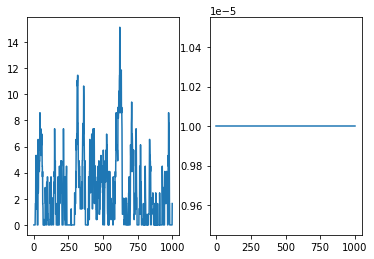

maximum steps, simulation is done ... 
elapsed_time: 49.354
Episode: 11 Exploration P: 0.8879 Total reward: -455.9061157965771 SOC: 1.0000 Cumulative_SOC_deviation: 338.9932 Fuel Consumption: 116.9129

maximum steps, simulation is done ... 
elapsed_time: 50.007
Episode: 12 Exploration P: 0.8705 Total reward: -433.99838321067045 SOC: 1.0000 Cumulative_SOC_deviation: 326.1758 Fuel Consumption: 107.8226

maximum steps, simulation is done ... 
elapsed_time: 51.385
Episode: 13 Exploration P: 0.8534 Total reward: -429.56981109396577 SOC: 1.0000 Cumulative_SOC_deviation: 342.1668 Fuel Consumption: 87.4030

maximum steps, simulation is done ... 
elapsed_time: 51.002
Episode: 14 Exploration P: 0.8367 Total reward: -431.2596529565212 SOC: 1.0000 Cumulative_SOC_deviation: 344.9916 Fuel Consumption: 86.2680

maximum steps, simulation is done ... 
elapsed_time: 50.150
Episode: 15 Exploration P: 0.8203 Total reward: -432.3917830714955 SOC: 1.0000 Cumulative_SOC_deviation: 346.4540 Fuel Consumption: 

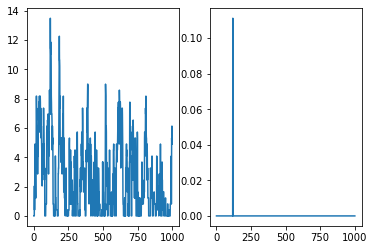

maximum steps, simulation is done ... 
elapsed_time: 50.916
Episode: 21 Exploration P: 0.7286 Total reward: -416.72463557847044 SOC: 0.9804 Cumulative_SOC_deviation: 334.5736 Fuel Consumption: 82.1511

maximum steps, simulation is done ... 
elapsed_time: 51.142
Episode: 22 Exploration P: 0.7144 Total reward: -408.5081381597434 SOC: 1.0000 Cumulative_SOC_deviation: 331.7122 Fuel Consumption: 76.7960

maximum steps, simulation is done ... 
elapsed_time: 50.456
Episode: 23 Exploration P: 0.7004 Total reward: -412.66032354864313 SOC: 1.0000 Cumulative_SOC_deviation: 328.8068 Fuel Consumption: 83.8536

maximum steps, simulation is done ... 
elapsed_time: 50.384
Episode: 24 Exploration P: 0.6867 Total reward: -399.15715306547634 SOC: 1.0000 Cumulative_SOC_deviation: 326.9734 Fuel Consumption: 72.1837

maximum steps, simulation is done ... 
elapsed_time: 50.457
Episode: 25 Exploration P: 0.6733 Total reward: -407.038583532661 SOC: 1.0000 Cumulative_SOC_deviation: 332.7293 Fuel Consumption: 74

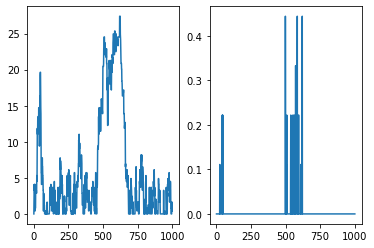

maximum steps, simulation is done ... 
elapsed_time: 50.328
Episode: 31 Exploration P: 0.5982 Total reward: -376.04331491203453 SOC: 1.0000 Cumulative_SOC_deviation: 311.4228 Fuel Consumption: 64.6205

maximum steps, simulation is done ... 
elapsed_time: 50.785
Episode: 32 Exploration P: 0.5866 Total reward: -393.60803116019554 SOC: 0.9958 Cumulative_SOC_deviation: 327.4294 Fuel Consumption: 66.1786

maximum steps, simulation is done ... 
elapsed_time: 50.783
Episode: 33 Exploration P: 0.5751 Total reward: -371.23421874923537 SOC: 1.0000 Cumulative_SOC_deviation: 310.4623 Fuel Consumption: 60.7719

maximum steps, simulation is done ... 
elapsed_time: 50.397
Episode: 34 Exploration P: 0.5639 Total reward: -383.9302706992646 SOC: 1.0000 Cumulative_SOC_deviation: 318.7629 Fuel Consumption: 65.1674

maximum steps, simulation is done ... 
elapsed_time: 50.639
Episode: 35 Exploration P: 0.5530 Total reward: -373.03879807705704 SOC: 0.9999 Cumulative_SOC_deviation: 309.3778 Fuel Consumption: 

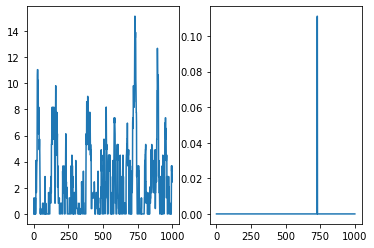

maximum steps, simulation is done ... 
elapsed_time: 50.134
Episode: 41 Exploration P: 0.4915 Total reward: -344.97807708697474 SOC: 0.9998 Cumulative_SOC_deviation: 287.2191 Fuel Consumption: 57.7590

maximum steps, simulation is done ... 
elapsed_time: 50.578
Episode: 42 Exploration P: 0.4820 Total reward: -367.82594660357097 SOC: 1.0000 Cumulative_SOC_deviation: 310.2217 Fuel Consumption: 57.6042

maximum steps, simulation is done ... 
elapsed_time: 50.713
Episode: 43 Exploration P: 0.4726 Total reward: -347.0912468098175 SOC: 0.9952 Cumulative_SOC_deviation: 296.2248 Fuel Consumption: 50.8665

maximum steps, simulation is done ... 
elapsed_time: 50.562
Episode: 44 Exploration P: 0.4634 Total reward: -323.5012258804576 SOC: 0.9992 Cumulative_SOC_deviation: 263.2349 Fuel Consumption: 60.2663

maximum steps, simulation is done ... 
elapsed_time: 50.796
Episode: 45 Exploration P: 0.4544 Total reward: -354.0551662681485 SOC: 1.0000 Cumulative_SOC_deviation: 300.1448 Fuel Consumption: 53

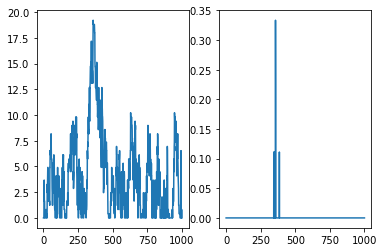

maximum steps, simulation is done ... 
elapsed_time: 50.366
Episode: 51 Exploration P: 0.4041 Total reward: -283.9735743168661 SOC: 1.0000 Cumulative_SOC_deviation: 231.7038 Fuel Consumption: 52.2697

maximum steps, simulation is done ... 
elapsed_time: 51.086
Episode: 52 Exploration P: 0.3963 Total reward: -329.3579697295848 SOC: 1.0000 Cumulative_SOC_deviation: 280.8337 Fuel Consumption: 48.5243

maximum steps, simulation is done ... 
elapsed_time: 51.127
Episode: 53 Exploration P: 0.3887 Total reward: -313.34870062834534 SOC: 1.0000 Cumulative_SOC_deviation: 266.9500 Fuel Consumption: 46.3987

maximum steps, simulation is done ... 
elapsed_time: 50.976
Episode: 54 Exploration P: 0.3812 Total reward: -335.0192963458244 SOC: 1.0000 Cumulative_SOC_deviation: 285.1640 Fuel Consumption: 49.8553

maximum steps, simulation is done ... 
elapsed_time: 50.564
Episode: 55 Exploration P: 0.3738 Total reward: -294.61849493076926 SOC: 0.9905 Cumulative_SOC_deviation: 245.0005 Fuel Consumption: 49

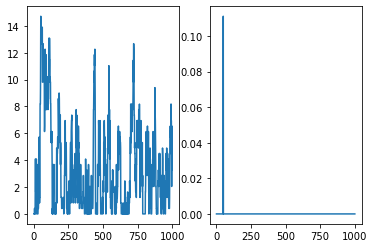

maximum steps, simulation is done ... 
elapsed_time: 50.489
Episode: 61 Exploration P: 0.3326 Total reward: -252.04461814064473 SOC: 1.0000 Cumulative_SOC_deviation: 201.6837 Fuel Consumption: 50.3609

maximum steps, simulation is done ... 
elapsed_time: 51.076
Episode: 62 Exploration P: 0.3262 Total reward: -259.1511537377858 SOC: 0.9836 Cumulative_SOC_deviation: 216.6630 Fuel Consumption: 42.4881

maximum steps, simulation is done ... 
elapsed_time: 51.192
Episode: 63 Exploration P: 0.3200 Total reward: -185.07859665909743 SOC: 0.8387 Cumulative_SOC_deviation: 134.9138 Fuel Consumption: 50.1648

battery power is 107887.84392106404(+) but condition is not avail
elapsed_time: 27.513
Episode: 64 Exploration P: 0.3166 Total reward: -1059.1496495622553 SOC: 0.5407 Cumulative_SOC_deviation: 25.0101 Fuel Consumption: 34.1988

maximum steps, simulation is done ... 
elapsed_time: 50.827
Episode: 65 Exploration P: 0.3105 Total reward: -260.86470564041645 SOC: 0.9494 Cumulative_SOC_deviation: 2

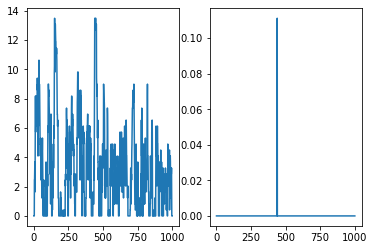

maximum steps, simulation is done ... 
elapsed_time: 49.075
Episode: 71 Exploration P: 0.2765 Total reward: -217.97770144564257 SOC: 0.8623 Cumulative_SOC_deviation: 174.9427 Fuel Consumption: 43.0350

maximum steps, simulation is done ... 
elapsed_time: 50.828
Episode: 72 Exploration P: 0.2712 Total reward: -204.858188366605 SOC: 0.9279 Cumulative_SOC_deviation: 164.0725 Fuel Consumption: 40.7856

maximum steps, simulation is done ... 
elapsed_time: 50.859
Episode: 73 Exploration P: 0.2661 Total reward: -239.41108980238934 SOC: 0.9392 Cumulative_SOC_deviation: 202.5257 Fuel Consumption: 36.8854

maximum steps, simulation is done ... 
elapsed_time: 50.900
Episode: 74 Exploration P: 0.2610 Total reward: -239.71094726096078 SOC: 0.9613 Cumulative_SOC_deviation: 203.0319 Fuel Consumption: 36.6790

maximum steps, simulation is done ... 
elapsed_time: 50.835
Episode: 75 Exploration P: 0.2560 Total reward: -189.1346032736078 SOC: 0.8900 Cumulative_SOC_deviation: 151.3928 Fuel Consumption: 37

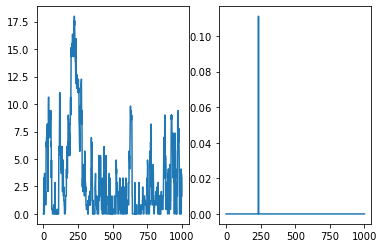

maximum steps, simulation is done ... 
elapsed_time: 50.521
Episode: 81 Exploration P: 0.2282 Total reward: -179.98132965366435 SOC: 0.8734 Cumulative_SOC_deviation: 147.9867 Fuel Consumption: 31.9946

maximum steps, simulation is done ... 
elapsed_time: 52.380
Episode: 82 Exploration P: 0.2238 Total reward: -166.62000761450142 SOC: 0.7906 Cumulative_SOC_deviation: 131.2720 Fuel Consumption: 35.3480

maximum steps, simulation is done ... 
elapsed_time: 51.893
Episode: 83 Exploration P: 0.2196 Total reward: -191.33557111865838 SOC: 0.8760 Cumulative_SOC_deviation: 155.8534 Fuel Consumption: 35.4821

maximum steps, simulation is done ... 
elapsed_time: 51.533
Episode: 84 Exploration P: 0.2155 Total reward: -132.869777524308 SOC: 0.8042 Cumulative_SOC_deviation: 102.7840 Fuel Consumption: 30.0857

maximum steps, simulation is done ... 
elapsed_time: 51.398
Episode: 85 Exploration P: 0.2114 Total reward: -164.01695088642987 SOC: 0.8079 Cumulative_SOC_deviation: 129.5873 Fuel Consumption: 3

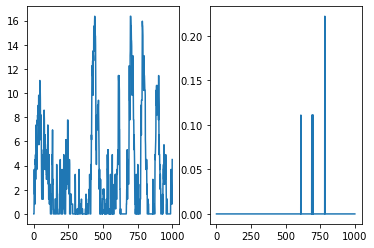

maximum steps, simulation is done ... 
elapsed_time: 50.922
Episode: 91 Exploration P: 0.1886 Total reward: -139.1646455216519 SOC: 0.8158 Cumulative_SOC_deviation: 107.3248 Fuel Consumption: 31.8398

maximum steps, simulation is done ... 
elapsed_time: 51.295
Episode: 92 Exploration P: 0.1850 Total reward: -135.3089874819987 SOC: 0.7779 Cumulative_SOC_deviation: 108.3496 Fuel Consumption: 26.9593

maximum steps, simulation is done ... 
elapsed_time: 51.357
Episode: 93 Exploration P: 0.1816 Total reward: -110.93433235151103 SOC: 0.7768 Cumulative_SOC_deviation: 88.0919 Fuel Consumption: 22.8424

maximum steps, simulation is done ... 
elapsed_time: 51.346
Episode: 94 Exploration P: 0.1782 Total reward: -101.69921122730922 SOC: 0.7786 Cumulative_SOC_deviation: 78.2790 Fuel Consumption: 23.4202

maximum steps, simulation is done ... 
elapsed_time: 51.310
Episode: 95 Exploration P: 0.1748 Total reward: -99.25570786347451 SOC: 0.5337 Cumulative_SOC_deviation: 71.2542 Fuel Consumption: 28.00

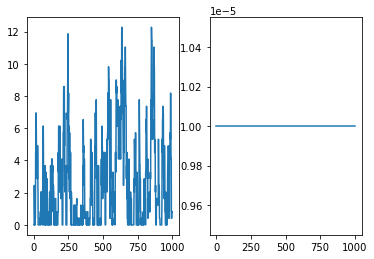

maximum steps, simulation is done ... 
elapsed_time: 51.119
Episode: 101 Exploration P: 0.1562 Total reward: -129.8281390862759 SOC: 0.7975 Cumulative_SOC_deviation: 107.6048 Fuel Consumption: 22.2233

maximum steps, simulation is done ... 
elapsed_time: 51.263
Episode: 102 Exploration P: 0.1533 Total reward: -77.5312198238959 SOC: 0.7479 Cumulative_SOC_deviation: 51.5108 Fuel Consumption: 26.0204

maximum steps, simulation is done ... 
elapsed_time: 51.829
Episode: 103 Exploration P: 0.1504 Total reward: -155.8661259977823 SOC: 0.4085 Cumulative_SOC_deviation: 125.9661 Fuel Consumption: 29.9000

maximum steps, simulation is done ... 
elapsed_time: 51.281
Episode: 104 Exploration P: 0.1477 Total reward: -159.0015859322151 SOC: 0.4165 Cumulative_SOC_deviation: 131.4541 Fuel Consumption: 27.5475

maximum steps, simulation is done ... 
elapsed_time: 51.323
Episode: 105 Exploration P: 0.1449 Total reward: -133.3477474587937 SOC: 0.8034 Cumulative_SOC_deviation: 111.2070 Fuel Consumption: 2

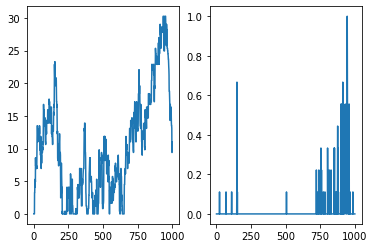

maximum steps, simulation is done ... 
elapsed_time: 51.162
Episode: 111 Exploration P: 0.1297 Total reward: -69.27279496318927 SOC: 0.7024 Cumulative_SOC_deviation: 47.5138 Fuel Consumption: 21.7590

maximum steps, simulation is done ... 
elapsed_time: 50.997
Episode: 112 Exploration P: 0.1273 Total reward: -35.21406311918414 SOC: 0.6641 Cumulative_SOC_deviation: 19.0784 Fuel Consumption: 16.1356

maximum steps, simulation is done ... 
elapsed_time: 50.790
Episode: 113 Exploration P: 0.1250 Total reward: -67.53031318511378 SOC: 0.5941 Cumulative_SOC_deviation: 46.2666 Fuel Consumption: 21.2637

maximum steps, simulation is done ... 
elapsed_time: 50.963
Episode: 114 Exploration P: 0.1227 Total reward: -38.43688118804349 SOC: 0.6541 Cumulative_SOC_deviation: 19.2677 Fuel Consumption: 19.1691

maximum steps, simulation is done ... 
elapsed_time: 51.299
Episode: 115 Exploration P: 0.1205 Total reward: -99.98827100852158 SOC: 0.7419 Cumulative_SOC_deviation: 78.1055 Fuel Consumption: 21.8

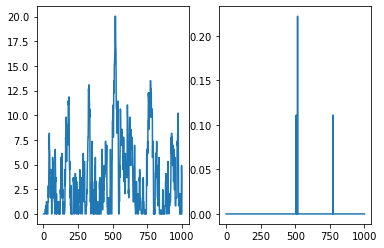

maximum steps, simulation is done ... 
elapsed_time: 51.228
Episode: 121 Exploration P: 0.1080 Total reward: -60.003954459562436 SOC: 0.6774 Cumulative_SOC_deviation: 43.3937 Fuel Consumption: 16.6103

maximum steps, simulation is done ... 
elapsed_time: 51.456
Episode: 122 Exploration P: 0.1060 Total reward: -42.794628488059296 SOC: 0.6352 Cumulative_SOC_deviation: 25.0494 Fuel Consumption: 17.7452

maximum steps, simulation is done ... 
elapsed_time: 51.286
Episode: 123 Exploration P: 0.1041 Total reward: -35.14983916647463 SOC: 0.6625 Cumulative_SOC_deviation: 20.2008 Fuel Consumption: 14.9490

maximum steps, simulation is done ... 
elapsed_time: 51.298
Episode: 124 Exploration P: 0.1022 Total reward: -53.106744692791025 SOC: 0.6381 Cumulative_SOC_deviation: 37.2394 Fuel Consumption: 15.8673

maximum steps, simulation is done ... 
elapsed_time: 51.458
Episode: 125 Exploration P: 0.1004 Total reward: -79.63850965120193 SOC: 0.5292 Cumulative_SOC_deviation: 62.2441 Fuel Consumption: 1

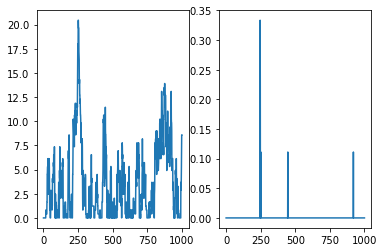

maximum steps, simulation is done ... 
elapsed_time: 51.385
Episode: 131 Exploration P: 0.0902 Total reward: -38.624176286039095 SOC: 0.6434 Cumulative_SOC_deviation: 24.6554 Fuel Consumption: 13.9688

maximum steps, simulation is done ... 
elapsed_time: 51.409
Episode: 132 Exploration P: 0.0886 Total reward: -22.459519945902706 SOC: 0.6256 Cumulative_SOC_deviation: 11.3901 Fuel Consumption: 11.0694

maximum steps, simulation is done ... 
elapsed_time: 51.130
Episode: 133 Exploration P: 0.0870 Total reward: -40.97911353238299 SOC: 0.6581 Cumulative_SOC_deviation: 28.0731 Fuel Consumption: 12.9060

battery power is 120301.82784268272(+) but condition is not avail
elapsed_time: 40.214
Episode: 134 Exploration P: 0.0858 Total reward: -1065.0636064058442 SOC: 0.2362 Cumulative_SOC_deviation: 42.2876 Fuel Consumption: 23.1399

maximum steps, simulation is done ... 
elapsed_time: 51.091
Episode: 135 Exploration P: 0.0843 Total reward: -38.382099649406946 SOC: 0.5747 Cumulative_SOC_deviation:

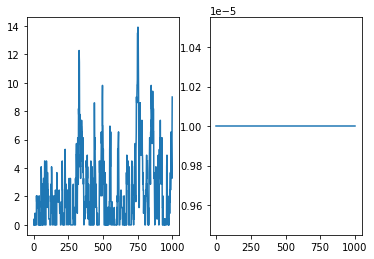

maximum steps, simulation is done ... 
elapsed_time: 50.628
Episode: 141 Exploration P: 0.0759 Total reward: -21.43950020453968 SOC: 0.6246 Cumulative_SOC_deviation: 9.2660 Fuel Consumption: 12.1735

maximum steps, simulation is done ... 
elapsed_time: 51.454
Episode: 142 Exploration P: 0.0746 Total reward: -22.325670223393356 SOC: 0.6171 Cumulative_SOC_deviation: 11.3801 Fuel Consumption: 10.9456

maximum steps, simulation is done ... 
elapsed_time: 51.216
Episode: 143 Exploration P: 0.0733 Total reward: -86.96213063765322 SOC: 0.4417 Cumulative_SOC_deviation: 73.6021 Fuel Consumption: 13.3600

maximum steps, simulation is done ... 
elapsed_time: 51.231
Episode: 144 Exploration P: 0.0721 Total reward: -65.6956924060118 SOC: 0.4594 Cumulative_SOC_deviation: 52.8309 Fuel Consumption: 12.8648

maximum steps, simulation is done ... 
elapsed_time: 51.182
Episode: 145 Exploration P: 0.0708 Total reward: -35.19214214702397 SOC: 0.6034 Cumulative_SOC_deviation: 22.3171 Fuel Consumption: 12.87

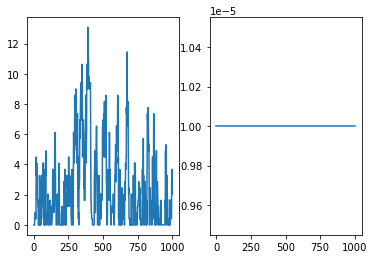

maximum steps, simulation is done ... 
elapsed_time: 51.424
Episode: 151 Exploration P: 0.0640 Total reward: -74.48767643770496 SOC: 0.5431 Cumulative_SOC_deviation: 62.4896 Fuel Consumption: 11.9980

battery power is 107887.84392106404(+) but condition is not avail
elapsed_time: 47.697
Episode: 152 Exploration P: 0.0630 Total reward: -1034.968484368669 SOC: 0.4335 Cumulative_SOC_deviation: 23.9837 Fuel Consumption: 11.1513

maximum steps, simulation is done ... 
elapsed_time: 51.762
Episode: 153 Exploration P: 0.0619 Total reward: -82.59402819958416 SOC: 0.4815 Cumulative_SOC_deviation: 73.0207 Fuel Consumption: 9.5733

maximum steps, simulation is done ... 
elapsed_time: 51.747
Episode: 154 Exploration P: 0.0609 Total reward: -21.31930499544719 SOC: 0.6248 Cumulative_SOC_deviation: 11.2404 Fuel Consumption: 10.0789

maximum steps, simulation is done ... 
elapsed_time: 52.136
Episode: 155 Exploration P: 0.0599 Total reward: -23.60026361532018 SOC: 0.6183 Cumulative_SOC_deviation: 11.2

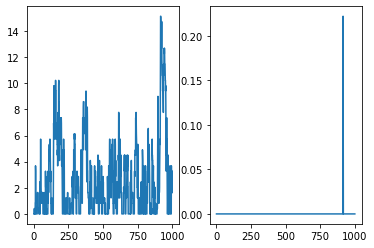

maximum steps, simulation is done ... 
elapsed_time: 51.081
Episode: 161 Exploration P: 0.0542 Total reward: -44.34979903680195 SOC: 0.4869 Cumulative_SOC_deviation: 32.8573 Fuel Consumption: 11.4925

maximum steps, simulation is done ... 
elapsed_time: 51.605
Episode: 162 Exploration P: 0.0533 Total reward: -43.412563573943345 SOC: 0.5288 Cumulative_SOC_deviation: 32.9932 Fuel Consumption: 10.4194

maximum steps, simulation is done ... 
elapsed_time: 51.807
Episode: 163 Exploration P: 0.0525 Total reward: -22.072231483993225 SOC: 0.5674 Cumulative_SOC_deviation: 12.5918 Fuel Consumption: 9.4804

maximum steps, simulation is done ... 
elapsed_time: 51.881
Episode: 164 Exploration P: 0.0516 Total reward: -20.276272149848264 SOC: 0.5879 Cumulative_SOC_deviation: 9.1450 Fuel Consumption: 11.1313

maximum steps, simulation is done ... 
elapsed_time: 51.704
Episode: 165 Exploration P: 0.0508 Total reward: -28.983462677463443 SOC: 0.5535 Cumulative_SOC_deviation: 20.0293 Fuel Consumption: 8.

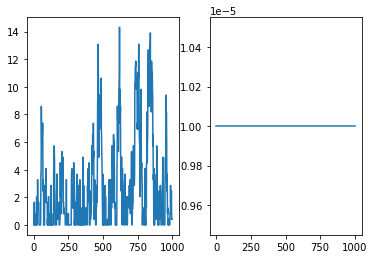

maximum steps, simulation is done ... 
elapsed_time: 50.979
Episode: 171 Exploration P: 0.0462 Total reward: -20.58806211362019 SOC: 0.5596 Cumulative_SOC_deviation: 12.7379 Fuel Consumption: 7.8502

maximum steps, simulation is done ... 
elapsed_time: 51.102
Episode: 172 Exploration P: 0.0455 Total reward: -12.807134281020566 SOC: 0.5845 Cumulative_SOC_deviation: 7.1238 Fuel Consumption: 5.6833

maximum steps, simulation is done ... 
elapsed_time: 50.836
Episode: 173 Exploration P: 0.0448 Total reward: -96.11514012450877 SOC: 0.4485 Cumulative_SOC_deviation: 89.1730 Fuel Consumption: 6.9422

maximum steps, simulation is done ... 
elapsed_time: 51.303
Episode: 174 Exploration P: 0.0441 Total reward: -18.039222041180647 SOC: 0.5696 Cumulative_SOC_deviation: 11.2931 Fuel Consumption: 6.7461

maximum steps, simulation is done ... 
elapsed_time: 50.629
Episode: 175 Exploration P: 0.0434 Total reward: -39.94709856740416 SOC: 0.5379 Cumulative_SOC_deviation: 33.7685 Fuel Consumption: 6.1786


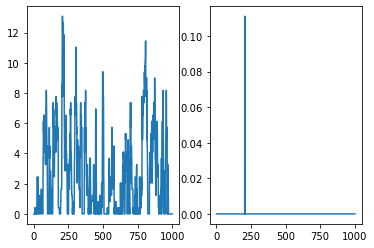

maximum steps, simulation is done ... 
elapsed_time: 50.874
Episode: 181 Exploration P: 0.0396 Total reward: -62.91976723427051 SOC: 0.5200 Cumulative_SOC_deviation: 55.2966 Fuel Consumption: 7.6232

maximum steps, simulation is done ... 
elapsed_time: 51.199
Episode: 182 Exploration P: 0.0390 Total reward: -73.09867377082007 SOC: 0.5169 Cumulative_SOC_deviation: 67.0026 Fuel Consumption: 6.0961

maximum steps, simulation is done ... 
elapsed_time: 50.976
Episode: 183 Exploration P: 0.0385 Total reward: -31.038120882837692 SOC: 0.4884 Cumulative_SOC_deviation: 26.5826 Fuel Consumption: 4.4555

maximum steps, simulation is done ... 
elapsed_time: 51.197
Episode: 184 Exploration P: 0.0379 Total reward: -25.177575044585492 SOC: 0.5629 Cumulative_SOC_deviation: 19.3291 Fuel Consumption: 5.8484

maximum steps, simulation is done ... 
elapsed_time: 51.275
Episode: 185 Exploration P: 0.0374 Total reward: -43.438224713024155 SOC: 0.5369 Cumulative_SOC_deviation: 39.1685 Fuel Consumption: 4.269

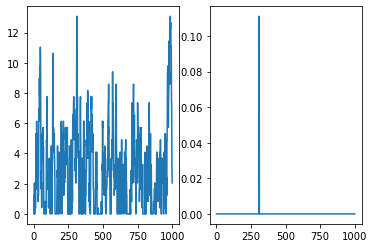

maximum steps, simulation is done ... 
elapsed_time: 50.571
Episode: 191 Exploration P: 0.0343 Total reward: -57.54581618698731 SOC: 0.5171 Cumulative_SOC_deviation: 52.5332 Fuel Consumption: 5.0127

maximum steps, simulation is done ... 
elapsed_time: 51.375
Episode: 192 Exploration P: 0.0338 Total reward: -65.90892155760025 SOC: 0.5081 Cumulative_SOC_deviation: 60.0914 Fuel Consumption: 5.8175

maximum steps, simulation is done ... 
elapsed_time: 51.262
Episode: 193 Exploration P: 0.0334 Total reward: -117.60615781085369 SOC: 0.4305 Cumulative_SOC_deviation: 112.4078 Fuel Consumption: 5.1984

maximum steps, simulation is done ... 
elapsed_time: 51.090
Episode: 194 Exploration P: 0.0329 Total reward: -57.906105722651354 SOC: 0.5122 Cumulative_SOC_deviation: 53.3165 Fuel Consumption: 4.5896

maximum steps, simulation is done ... 
elapsed_time: 50.834
Episode: 195 Exploration P: 0.0324 Total reward: -295.2258722718781 SOC: 0.2186 Cumulative_SOC_deviation: 282.0825 Fuel Consumption: 13.1

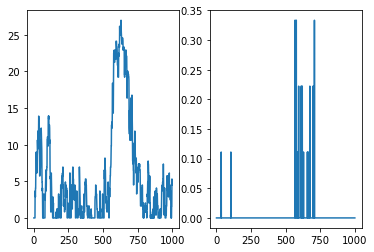

maximum steps, simulation is done ... 
elapsed_time: 50.642
Episode: 201 Exploration P: 0.0299 Total reward: -52.177790015444195 SOC: 0.4946 Cumulative_SOC_deviation: 45.5245 Fuel Consumption: 6.6532

maximum steps, simulation is done ... 
elapsed_time: 51.168
Episode: 202 Exploration P: 0.0295 Total reward: -47.342194373900746 SOC: 0.4824 Cumulative_SOC_deviation: 42.6288 Fuel Consumption: 4.7134

maximum steps, simulation is done ... 
elapsed_time: 50.935
Episode: 203 Exploration P: 0.0291 Total reward: -7.8322160155929135 SOC: 0.5954 Cumulative_SOC_deviation: 3.7379 Fuel Consumption: 4.0943

maximum steps, simulation is done ... 
elapsed_time: 51.051
Episode: 204 Exploration P: 0.0287 Total reward: -78.98240740915602 SOC: 0.4153 Cumulative_SOC_deviation: 74.5269 Fuel Consumption: 4.4555

maximum steps, simulation is done ... 
elapsed_time: 51.414
Episode: 205 Exploration P: 0.0284 Total reward: -36.65799536283832 SOC: 0.5462 Cumulative_SOC_deviation: 31.8826 Fuel Consumption: 4.7753

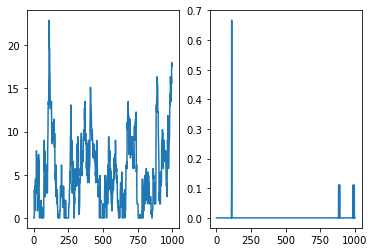

maximum steps, simulation is done ... 
elapsed_time: 50.589
Episode: 211 Exploration P: 0.0263 Total reward: -66.80068805798494 SOC: 0.4703 Cumulative_SOC_deviation: 64.5739 Fuel Consumption: 2.2268

maximum steps, simulation is done ... 
elapsed_time: 50.696
Episode: 212 Exploration P: 0.0260 Total reward: -238.97019448989136 SOC: 0.2995 Cumulative_SOC_deviation: 231.0169 Fuel Consumption: 7.9533

maximum steps, simulation is done ... 
elapsed_time: 50.901
Episode: 213 Exploration P: 0.0257 Total reward: -45.20915899324432 SOC: 0.5229 Cumulative_SOC_deviation: 41.0529 Fuel Consumption: 4.1563

battery power is 114038.7470972353(+) but condition is not avail
elapsed_time: 10.798
Episode: 214 Exploration P: 0.0256 Total reward: -1025.1056422181018 SOC: 0.3158 Cumulative_SOC_deviation: 18.8361 Fuel Consumption: 6.5538

maximum steps, simulation is done ... 
elapsed_time: 50.900
Episode: 215 Exploration P: 0.0253 Total reward: -130.30707922944245 SOC: 0.3897 Cumulative_SOC_deviation: 125.

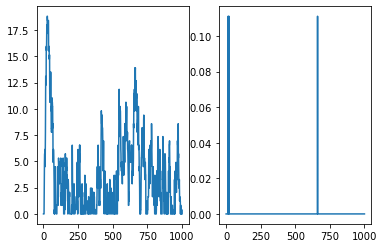

maximum steps, simulation is done ... 
elapsed_time: 49.838
Episode: 221 Exploration P: 0.0235 Total reward: -60.606210609915166 SOC: 0.4734 Cumulative_SOC_deviation: 56.8936 Fuel Consumption: 3.7126

maximum steps, simulation is done ... 
elapsed_time: 51.216
Episode: 222 Exploration P: 0.0233 Total reward: -43.31151789490281 SOC: 0.5270 Cumulative_SOC_deviation: 41.6935 Fuel Consumption: 1.6180

maximum steps, simulation is done ... 
elapsed_time: 51.046
Episode: 223 Exploration P: 0.0230 Total reward: -80.42502061296727 SOC: 0.4014 Cumulative_SOC_deviation: 76.4648 Fuel Consumption: 3.9602

maximum steps, simulation is done ... 
elapsed_time: 52.870
Episode: 224 Exploration P: 0.0228 Total reward: -48.4016848068533 SOC: 0.5096 Cumulative_SOC_deviation: 46.1130 Fuel Consumption: 2.2887

maximum steps, simulation is done ... 
elapsed_time: 50.980
Episode: 225 Exploration P: 0.0225 Total reward: -62.20444381294902 SOC: 0.4878 Cumulative_SOC_deviation: 59.1419 Fuel Consumption: 3.0625



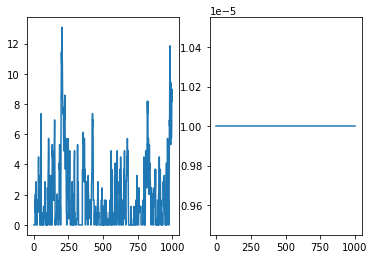

maximum steps, simulation is done ... 
elapsed_time: 50.527
Episode: 231 Exploration P: 0.0212 Total reward: -28.863153638601922 SOC: 0.5497 Cumulative_SOC_deviation: 24.8410 Fuel Consumption: 4.0221

maximum steps, simulation is done ... 
elapsed_time: 50.647
Episode: 232 Exploration P: 0.0209 Total reward: -46.14776529833344 SOC: 0.4248 Cumulative_SOC_deviation: 41.8367 Fuel Consumption: 4.3110

maximum steps, simulation is done ... 
elapsed_time: 51.340
Episode: 233 Exploration P: 0.0207 Total reward: -201.45127230952045 SOC: 0.3187 Cumulative_SOC_deviation: 193.7662 Fuel Consumption: 7.6851

maximum steps, simulation is done ... 
elapsed_time: 51.277
Episode: 234 Exploration P: 0.0205 Total reward: -118.20654940159807 SOC: 0.3895 Cumulative_SOC_deviation: 112.7605 Fuel Consumption: 5.4460

maximum steps, simulation is done ... 
elapsed_time: 51.314
Episode: 235 Exploration P: 0.0203 Total reward: -31.89310435035978 SOC: 0.5314 Cumulative_SOC_deviation: 30.1410 Fuel Consumption: 1.7

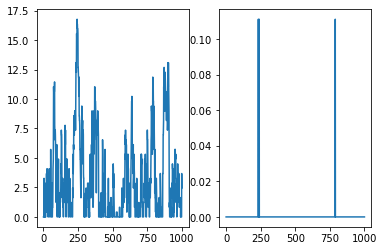

maximum steps, simulation is done ... 
elapsed_time: 50.537
Episode: 241 Exploration P: 0.0191 Total reward: -77.4117123739686 SOC: 0.4349 Cumulative_SOC_deviation: 73.1213 Fuel Consumption: 4.2904

maximum steps, simulation is done ... 
elapsed_time: 50.267
Episode: 242 Exploration P: 0.0189 Total reward: -35.80392303782458 SOC: 0.5318 Cumulative_SOC_deviation: 33.6287 Fuel Consumption: 2.1752

maximum steps, simulation is done ... 
elapsed_time: 51.228
Episode: 243 Exploration P: 0.0188 Total reward: -31.109303493021528 SOC: 0.5138 Cumulative_SOC_deviation: 28.4698 Fuel Consumption: 2.6395

maximum steps, simulation is done ... 
elapsed_time: 51.282
Episode: 244 Exploration P: 0.0186 Total reward: -49.97118812127753 SOC: 0.4569 Cumulative_SOC_deviation: 46.8571 Fuel Consumption: 3.1141

maximum steps, simulation is done ... 
elapsed_time: 51.220
Episode: 245 Exploration P: 0.0184 Total reward: -96.81289222825727 SOC: 0.4401 Cumulative_SOC_deviation: 94.0083 Fuel Consumption: 2.8046



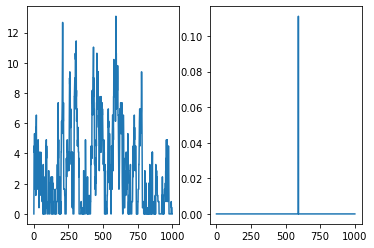

maximum steps, simulation is done ... 
elapsed_time: 50.135
Episode: 251 Exploration P: 0.0175 Total reward: -56.19057028077065 SOC: 0.5060 Cumulative_SOC_deviation: 54.2424 Fuel Consumption: 1.9482

maximum steps, simulation is done ... 
elapsed_time: 50.040
Episode: 252 Exploration P: 0.0173 Total reward: -53.79305113642127 SOC: 0.5060 Cumulative_SOC_deviation: 51.8449 Fuel Consumption: 1.9482

maximum steps, simulation is done ... 
elapsed_time: 50.697
Episode: 253 Exploration P: 0.0172 Total reward: -69.39614255846037 SOC: 0.4543 Cumulative_SOC_deviation: 66.7360 Fuel Consumption: 2.6601

maximum steps, simulation is done ... 
elapsed_time: 50.817
Episode: 254 Exploration P: 0.0170 Total reward: -28.75353169389924 SOC: 0.5212 Cumulative_SOC_deviation: 26.4545 Fuel Consumption: 2.2990

maximum steps, simulation is done ... 
elapsed_time: 51.136
Episode: 255 Exploration P: 0.0169 Total reward: -59.2909028822067 SOC: 0.4769 Cumulative_SOC_deviation: 57.0435 Fuel Consumption: 2.2474

m

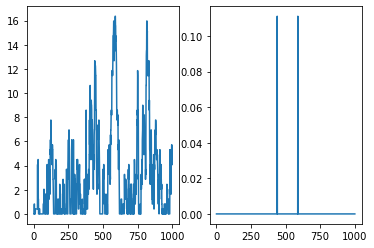

maximum steps, simulation is done ... 
elapsed_time: 50.372
Episode: 261 Exploration P: 0.0161 Total reward: -145.5850016712373 SOC: 0.3122 Cumulative_SOC_deviation: 140.7684 Fuel Consumption: 4.8166

maximum steps, simulation is done ... 
elapsed_time: 50.567
Episode: 262 Exploration P: 0.0160 Total reward: -48.770191936077254 SOC: 0.4915 Cumulative_SOC_deviation: 46.3680 Fuel Consumption: 2.4022

maximum steps, simulation is done ... 
elapsed_time: 51.354
Episode: 263 Exploration P: 0.0159 Total reward: -27.110653437659234 SOC: 0.5142 Cumulative_SOC_deviation: 24.5847 Fuel Consumption: 2.5260

maximum steps, simulation is done ... 
elapsed_time: 51.220
Episode: 264 Exploration P: 0.0158 Total reward: -163.39457079066074 SOC: 0.2619 Cumulative_SOC_deviation: 159.1558 Fuel Consumption: 4.2388

maximum steps, simulation is done ... 
elapsed_time: 51.524
Episode: 265 Exploration P: 0.0156 Total reward: -78.03208887884412 SOC: 0.4340 Cumulative_SOC_deviation: 74.9489 Fuel Consumption: 3.0

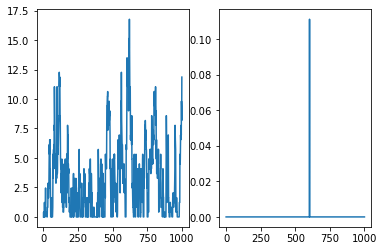

maximum steps, simulation is done ... 
elapsed_time: 50.796
Episode: 271 Exploration P: 0.0150 Total reward: -30.788941150686878 SOC: 0.5256 Cumulative_SOC_deviation: 29.4805 Fuel Consumption: 1.3085

maximum steps, simulation is done ... 
elapsed_time: 50.686
Episode: 272 Exploration P: 0.0149 Total reward: -46.2259165897108 SOC: 0.5164 Cumulative_SOC_deviation: 43.8444 Fuel Consumption: 2.3815

maximum steps, simulation is done ... 
elapsed_time: 51.497
Episode: 273 Exploration P: 0.0148 Total reward: -100.91074797758397 SOC: 0.4137 Cumulative_SOC_deviation: 96.3934 Fuel Consumption: 4.5174

maximum steps, simulation is done ... 
elapsed_time: 51.149
Episode: 274 Exploration P: 0.0147 Total reward: -37.15899531320948 SOC: 0.5327 Cumulative_SOC_deviation: 34.3544 Fuel Consumption: 2.8046

maximum steps, simulation is done ... 
elapsed_time: 51.449
Episode: 275 Exploration P: 0.0146 Total reward: -72.1678156909297 SOC: 0.4750 Cumulative_SOC_deviation: 68.8989 Fuel Consumption: 3.2689



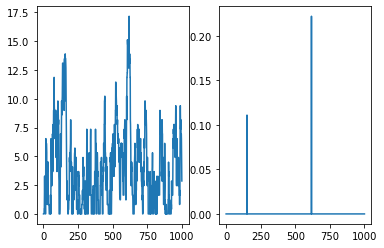

maximum steps, simulation is done ... 
elapsed_time: 50.333
Episode: 281 Exploration P: 0.0141 Total reward: -55.84964316631762 SOC: 0.5198 Cumulative_SOC_deviation: 53.7054 Fuel Consumption: 2.1442

maximum steps, simulation is done ... 
elapsed_time: 50.745
Episode: 282 Exploration P: 0.0140 Total reward: -86.03752884411743 SOC: 0.4345 Cumulative_SOC_deviation: 84.0481 Fuel Consumption: 1.9894

maximum steps, simulation is done ... 
elapsed_time: 51.365
Episode: 283 Exploration P: 0.0139 Total reward: -61.50871010212398 SOC: 0.4565 Cumulative_SOC_deviation: 60.2931 Fuel Consumption: 1.2156

maximum steps, simulation is done ... 
elapsed_time: 51.333
Episode: 284 Exploration P: 0.0139 Total reward: -74.07528191624041 SOC: 0.4825 Cumulative_SOC_deviation: 72.9010 Fuel Consumption: 1.1743

maximum steps, simulation is done ... 
elapsed_time: 51.217
Episode: 285 Exploration P: 0.0138 Total reward: -107.14711636186541 SOC: 0.3216 Cumulative_SOC_deviation: 99.7716 Fuel Consumption: 7.3755


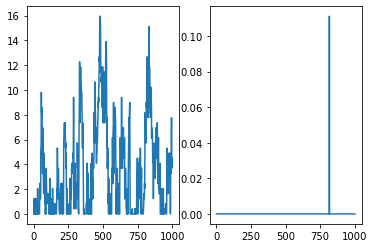

maximum steps, simulation is done ... 
elapsed_time: 50.163
Episode: 291 Exploration P: 0.0134 Total reward: -64.83630587309344 SOC: 0.4745 Cumulative_SOC_deviation: 62.9397 Fuel Consumption: 1.8966

maximum steps, simulation is done ... 
elapsed_time: 50.683
Episode: 292 Exploration P: 0.0133 Total reward: -47.49873912514218 SOC: 0.5135 Cumulative_SOC_deviation: 45.7879 Fuel Consumption: 1.7109

maximum steps, simulation is done ... 
elapsed_time: 51.566
Episode: 293 Exploration P: 0.0132 Total reward: -44.73352246770364 SOC: 0.4606 Cumulative_SOC_deviation: 41.5369 Fuel Consumption: 3.1967

maximum steps, simulation is done ... 
elapsed_time: 51.808
Episode: 294 Exploration P: 0.0132 Total reward: -44.3718025967054 SOC: 0.5063 Cumulative_SOC_deviation: 42.6300 Fuel Consumption: 1.7418

maximum steps, simulation is done ... 
elapsed_time: 51.507
Episode: 295 Exploration P: 0.0131 Total reward: -65.31527679939559 SOC: 0.4486 Cumulative_SOC_deviation: 63.8417 Fuel Consumption: 1.4735

m

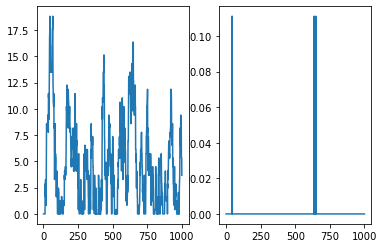

maximum steps, simulation is done ... 
elapsed_time: 50.397
Episode: 301 Exploration P: 0.0127 Total reward: -96.8990234408536 SOC: 0.4015 Cumulative_SOC_deviation: 94.8580 Fuel Consumption: 2.0410

maximum steps, simulation is done ... 
elapsed_time: 50.686
Episode: 302 Exploration P: 0.0127 Total reward: -39.7087644692564 SOC: 0.5101 Cumulative_SOC_deviation: 37.9360 Fuel Consumption: 1.7728

maximum steps, simulation is done ... 
elapsed_time: 51.660
Episode: 303 Exploration P: 0.0126 Total reward: -87.61768624516976 SOC: 0.4389 Cumulative_SOC_deviation: 85.2361 Fuel Consumption: 2.3815

maximum steps, simulation is done ... 
elapsed_time: 51.516
Episode: 304 Exploration P: 0.0126 Total reward: -63.38523516459694 SOC: 0.4966 Cumulative_SOC_deviation: 62.2316 Fuel Consumption: 1.1537

maximum steps, simulation is done ... 
elapsed_time: 51.246
Episode: 305 Exploration P: 0.0125 Total reward: -99.03688917244845 SOC: 0.4280 Cumulative_SOC_deviation: 96.5728 Fuel Consumption: 2.4641

ma

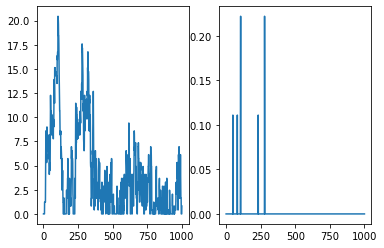

maximum steps, simulation is done ... 
elapsed_time: 50.284
Episode: 311 Exploration P: 0.0122 Total reward: -54.36133643894421 SOC: 0.4937 Cumulative_SOC_deviation: 52.5783 Fuel Consumption: 1.7831

maximum steps, simulation is done ... 
elapsed_time: 50.439
Episode: 312 Exploration P: 0.0122 Total reward: -137.67231565526518 SOC: 0.4044 Cumulative_SOC_deviation: 134.5685 Fuel Consumption: 3.1038

maximum steps, simulation is done ... 
elapsed_time: 51.252
Episode: 313 Exploration P: 0.0122 Total reward: -66.25022034639171 SOC: 0.4545 Cumulative_SOC_deviation: 64.8799 Fuel Consumption: 1.3704

maximum steps, simulation is done ... 
elapsed_time: 51.229
Episode: 314 Exploration P: 0.0121 Total reward: -263.1400191932904 SOC: 0.1446 Cumulative_SOC_deviation: 251.1213 Fuel Consumption: 12.0187

maximum steps, simulation is done ... 
elapsed_time: 51.103
Episode: 315 Exploration P: 0.0121 Total reward: -51.51397743478607 SOC: 0.5085 Cumulative_SOC_deviation: 49.2666 Fuel Consumption: 2.24

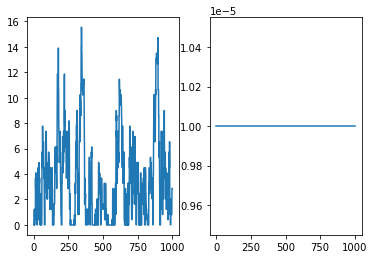

maximum steps, simulation is done ... 
elapsed_time: 50.095
Episode: 321 Exploration P: 0.0118 Total reward: -91.06820384350766 SOC: 0.4527 Cumulative_SOC_deviation: 89.1716 Fuel Consumption: 1.8966

maximum steps, simulation is done ... 
elapsed_time: 50.900
Episode: 322 Exploration P: 0.0118 Total reward: -141.48567203159945 SOC: 0.3854 Cumulative_SOC_deviation: 139.3002 Fuel Consumption: 2.1855

maximum steps, simulation is done ... 
elapsed_time: 51.403
Episode: 323 Exploration P: 0.0118 Total reward: -239.62370576485802 SOC: 0.2002 Cumulative_SOC_deviation: 229.7202 Fuel Consumption: 9.9035

maximum steps, simulation is done ... 
elapsed_time: 51.427
Episode: 324 Exploration P: 0.0117 Total reward: -68.29903912719182 SOC: 0.4811 Cumulative_SOC_deviation: 66.1032 Fuel Consumption: 2.1958

maximum steps, simulation is done ... 
elapsed_time: 51.384
Episode: 325 Exploration P: 0.0117 Total reward: -60.53604602650737 SOC: 0.4810 Cumulative_SOC_deviation: 59.3720 Fuel Consumption: 1.16

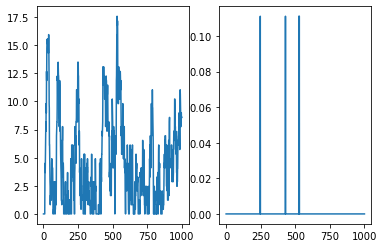

maximum steps, simulation is done ... 
elapsed_time: 50.694
Episode: 331 Exploration P: 0.0115 Total reward: -26.778078517629943 SOC: 0.5223 Cumulative_SOC_deviation: 24.8093 Fuel Consumption: 1.9688

maximum steps, simulation is done ... 
elapsed_time: 51.685
Episode: 332 Exploration P: 0.0115 Total reward: -64.91258044137791 SOC: 0.4206 Cumulative_SOC_deviation: 59.4666 Fuel Consumption: 5.4460

maximum steps, simulation is done ... 
elapsed_time: 51.322
Episode: 333 Exploration P: 0.0114 Total reward: -140.748974881499 SOC: 0.2753 Cumulative_SOC_deviation: 132.1043 Fuel Consumption: 8.6446

maximum steps, simulation is done ... 
elapsed_time: 51.383
Episode: 334 Exploration P: 0.0114 Total reward: -164.5988445458369 SOC: 0.3590 Cumulative_SOC_deviation: 161.4125 Fuel Consumption: 3.1864

maximum steps, simulation is done ... 
elapsed_time: 51.536
Episode: 335 Exploration P: 0.0114 Total reward: -111.22318433943425 SOC: 0.1571 Cumulative_SOC_deviation: 96.0575 Fuel Consumption: 15.16

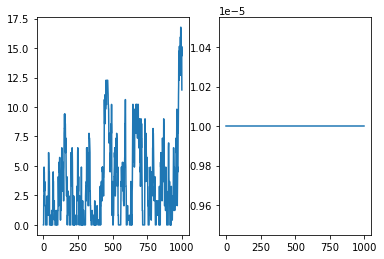

maximum steps, simulation is done ... 
elapsed_time: 50.887
Episode: 341 Exploration P: 0.0112 Total reward: -54.55513742357695 SOC: 0.4654 Cumulative_SOC_deviation: 52.8649 Fuel Consumption: 1.6902

maximum steps, simulation is done ... 
elapsed_time: 50.959
Episode: 342 Exploration P: 0.0112 Total reward: -58.05906364501723 SOC: 0.4811 Cumulative_SOC_deviation: 55.9148 Fuel Consumption: 2.1442

maximum steps, simulation is done ... 
elapsed_time: 51.126
Episode: 343 Exploration P: 0.0112 Total reward: -40.52136168987967 SOC: 0.4772 Cumulative_SOC_deviation: 38.9034 Fuel Consumption: 1.6180

maximum steps, simulation is done ... 
elapsed_time: 51.898
Episode: 344 Exploration P: 0.0112 Total reward: -73.84317098543558 SOC: 0.4718 Cumulative_SOC_deviation: 72.5347 Fuel Consumption: 1.3085

maximum steps, simulation is done ... 
elapsed_time: 51.430
Episode: 345 Exploration P: 0.0111 Total reward: -46.34988148397414 SOC: 0.5185 Cumulative_SOC_deviation: 43.7104 Fuel Consumption: 2.6395



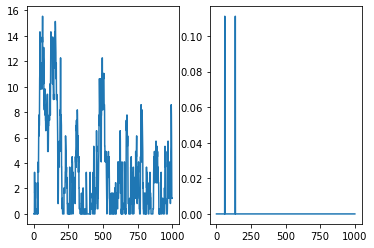

maximum steps, simulation is done ... 
elapsed_time: 51.370
Episode: 351 Exploration P: 0.0110 Total reward: -201.35589594071385 SOC: 0.1698 Cumulative_SOC_deviation: 192.3088 Fuel Consumption: 9.0471

maximum steps, simulation is done ... 
elapsed_time: 50.833
Episode: 352 Exploration P: 0.0110 Total reward: -126.62647416135736 SOC: 0.3212 Cumulative_SOC_deviation: 122.2742 Fuel Consumption: 4.3523

maximum steps, simulation is done ... 
elapsed_time: 50.892
Episode: 353 Exploration P: 0.0110 Total reward: -137.38890850628493 SOC: 0.3748 Cumulative_SOC_deviation: 133.4803 Fuel Consumption: 3.9086

maximum steps, simulation is done ... 
elapsed_time: 51.674
Episode: 354 Exploration P: 0.0110 Total reward: -98.59307796654775 SOC: 0.4156 Cumulative_SOC_deviation: 96.2425 Fuel Consumption: 2.3506

maximum steps, simulation is done ... 
elapsed_time: 51.473
Episode: 355 Exploration P: 0.0109 Total reward: -92.54081707998586 SOC: 0.4224 Cumulative_SOC_deviation: 89.4886 Fuel Consumption: 3.

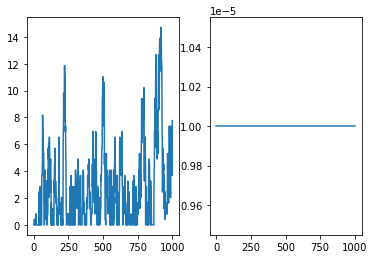

maximum steps, simulation is done ... 
elapsed_time: 51.144
Episode: 361 Exploration P: 0.0108 Total reward: -50.192696174689694 SOC: 0.4897 Cumulative_SOC_deviation: 48.6263 Fuel Consumption: 1.5664

maximum steps, simulation is done ... 
elapsed_time: 50.808
Episode: 362 Exploration P: 0.0108 Total reward: -50.76031431274259 SOC: 0.5006 Cumulative_SOC_deviation: 48.6780 Fuel Consumption: 2.0823

maximum steps, simulation is done ... 
elapsed_time: 51.139
Episode: 363 Exploration P: 0.0108 Total reward: -70.79922091482197 SOC: 0.4780 Cumulative_SOC_deviation: 70.2337 Fuel Consumption: 0.5655

maximum steps, simulation is done ... 
elapsed_time: 51.521
Episode: 364 Exploration P: 0.0108 Total reward: -69.80172157756293 SOC: 0.4346 Cumulative_SOC_deviation: 67.2860 Fuel Consumption: 2.5157

maximum steps, simulation is done ... 
elapsed_time: 51.619
Episode: 365 Exploration P: 0.0108 Total reward: -131.8041944812517 SOC: 0.3840 Cumulative_SOC_deviation: 129.0615 Fuel Consumption: 2.7427

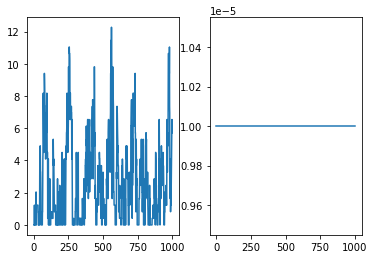

maximum steps, simulation is done ... 
elapsed_time: 50.957
Episode: 371 Exploration P: 0.0107 Total reward: -83.03075315182066 SOC: 0.4509 Cumulative_SOC_deviation: 81.2477 Fuel Consumption: 1.7831

maximum steps, simulation is done ... 
elapsed_time: 50.955
Episode: 372 Exploration P: 0.0107 Total reward: -59.642690491607816 SOC: 0.4903 Cumulative_SOC_deviation: 57.6120 Fuel Consumption: 2.0307

maximum steps, simulation is done ... 
elapsed_time: 51.407
Episode: 373 Exploration P: 0.0106 Total reward: -102.82813792735695 SOC: 0.4008 Cumulative_SOC_deviation: 99.9926 Fuel Consumption: 2.8355

maximum steps, simulation is done ... 
elapsed_time: 51.536
Episode: 374 Exploration P: 0.0106 Total reward: -44.03891843487985 SOC: 0.5029 Cumulative_SOC_deviation: 42.0392 Fuel Consumption: 1.9998

maximum steps, simulation is done ... 
elapsed_time: 51.408
Episode: 375 Exploration P: 0.0106 Total reward: -54.201390194586494 SOC: 0.4788 Cumulative_SOC_deviation: 52.2326 Fuel Consumption: 1.968

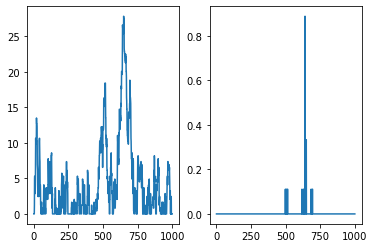

maximum steps, simulation is done ... 
elapsed_time: 50.916
Episode: 381 Exploration P: 0.0106 Total reward: -100.06753866386063 SOC: 0.4188 Cumulative_SOC_deviation: 97.8201 Fuel Consumption: 2.2474

maximum steps, simulation is done ... 
elapsed_time: 51.685
Episode: 382 Exploration P: 0.0105 Total reward: -66.00878833008787 SOC: 0.4947 Cumulative_SOC_deviation: 63.6273 Fuel Consumption: 2.3815

maximum steps, simulation is done ... 
elapsed_time: 51.466
Episode: 383 Exploration P: 0.0105 Total reward: -127.40442693191112 SOC: 0.4169 Cumulative_SOC_deviation: 125.5801 Fuel Consumption: 1.8244

maximum steps, simulation is done ... 
elapsed_time: 51.279
Episode: 384 Exploration P: 0.0105 Total reward: -43.048599084306716 SOC: 0.5091 Cumulative_SOC_deviation: 41.7401 Fuel Consumption: 1.3085

maximum steps, simulation is done ... 
elapsed_time: 51.765
Episode: 385 Exploration P: 0.0105 Total reward: -56.87030114010135 SOC: 0.4817 Cumulative_SOC_deviation: 54.4784 Fuel Consumption: 2.39

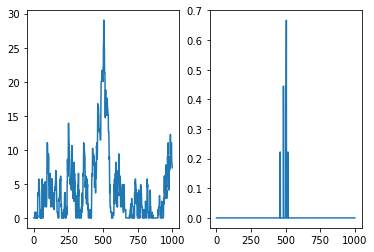

maximum steps, simulation is done ... 
elapsed_time: 50.738
Episode: 391 Exploration P: 0.0105 Total reward: -63.3944481962324 SOC: 0.4826 Cumulative_SOC_deviation: 62.1479 Fuel Consumption: 1.2465

maximum steps, simulation is done ... 
elapsed_time: 51.343
Episode: 392 Exploration P: 0.0104 Total reward: -33.59028091807581 SOC: 0.4946 Cumulative_SOC_deviation: 30.7960 Fuel Consumption: 2.7943

battery power is 104680.91856296756(+) but condition is not avail
elapsed_time: 49.351
Episode: 393 Exploration P: 0.0104 Total reward: -1055.6352011031497 SOC: 0.3820 Cumulative_SOC_deviation: 48.1065 Fuel Consumption: 7.7466

maximum steps, simulation is done ... 
elapsed_time: 51.317
Episode: 394 Exploration P: 0.0104 Total reward: -66.77037848159627 SOC: 0.4001 Cumulative_SOC_deviation: 64.8428 Fuel Consumption: 1.9275

maximum steps, simulation is done ... 
elapsed_time: 51.450
Episode: 395 Exploration P: 0.0104 Total reward: -37.071560992331094 SOC: 0.5396 Cumulative_SOC_deviation: 35.205

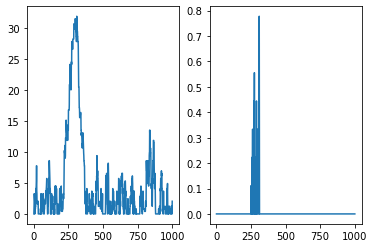

model is saved..

Trial 2

maximum steps, simulation is done ... 
elapsed_time: 7.095
Episode: 1 Exploration P: 1.0000 Total reward: -826.6455605028324 SOC: 1.0000 Cumulative_SOC_deviation: 357.5439 Fuel Consumption: 111.5578

maximum steps, simulation is done ... 
elapsed_time: 6.749
Episode: 2 Exploration P: 1.0000 Total reward: -806.6492983594418 SOC: 1.0000 Cumulative_SOC_deviation: 354.1803 Fuel Consumption: 98.2886

maximum steps, simulation is done ... 
elapsed_time: 7.298
Episode: 3 Exploration P: 1.0000 Total reward: -813.3888549334588 SOC: 1.0000 Cumulative_SOC_deviation: 347.4280 Fuel Consumption: 118.5328

maximum steps, simulation is done ... 
elapsed_time: 7.986
Episode: 4 Exploration P: 1.0000 Total reward: -799.0586268104827 SOC: 1.0000 Cumulative_SOC_deviation: 347.6404 Fuel Consumption: 103.7779


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model

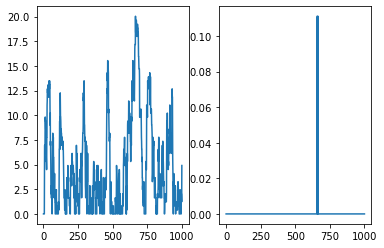

maximum steps, simulation is done ... 
elapsed_time: 49.896
Episode: 11 Exploration P: 0.8879 Total reward: -801.2801961590988 SOC: 1.0000 Cumulative_SOC_deviation: 348.8079 Fuel Consumption: 103.6644

maximum steps, simulation is done ... 
elapsed_time: 50.526
Episode: 12 Exploration P: 0.8705 Total reward: -768.8461623466385 SOC: 1.0000 Cumulative_SOC_deviation: 339.9580 Fuel Consumption: 88.9301

maximum steps, simulation is done ... 
elapsed_time: 50.829
Episode: 13 Exploration P: 0.8534 Total reward: -787.8162253832212 SOC: 0.9781 Cumulative_SOC_deviation: 347.6684 Fuel Consumption: 92.4795

maximum steps, simulation is done ... 
elapsed_time: 50.416
Episode: 14 Exploration P: 0.8367 Total reward: -771.0711168203787 SOC: 0.9980 Cumulative_SOC_deviation: 341.9011 Fuel Consumption: 87.2689

maximum steps, simulation is done ... 
elapsed_time: 50.464
Episode: 15 Exploration P: 0.8203 Total reward: -775.8652884839843 SOC: 1.0000 Cumulative_SOC_deviation: 341.9508 Fuel Consumption: 91.

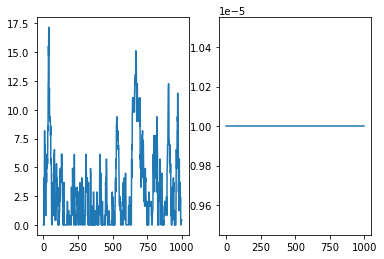

maximum steps, simulation is done ... 
elapsed_time: 50.140
Episode: 21 Exploration P: 0.7286 Total reward: -753.8242786844136 SOC: 0.9999 Cumulative_SOC_deviation: 337.1367 Fuel Consumption: 79.5509

maximum steps, simulation is done ... 
elapsed_time: 50.743
Episode: 22 Exploration P: 0.7144 Total reward: -753.3254138569024 SOC: 1.0000 Cumulative_SOC_deviation: 336.7789 Fuel Consumption: 79.7676

maximum steps, simulation is done ... 
elapsed_time: 50.788
Episode: 23 Exploration P: 0.7004 Total reward: -718.7553345706841 SOC: 1.0000 Cumulative_SOC_deviation: 323.5386 Fuel Consumption: 71.6782

maximum steps, simulation is done ... 
elapsed_time: 50.886
Episode: 24 Exploration P: 0.6867 Total reward: -744.7447409262395 SOC: 1.0000 Cumulative_SOC_deviation: 336.6674 Fuel Consumption: 71.4099

maximum steps, simulation is done ... 
elapsed_time: 50.865
Episode: 25 Exploration P: 0.6733 Total reward: -743.487327361181 SOC: 0.9771 Cumulative_SOC_deviation: 331.8186 Fuel Consumption: 79.85

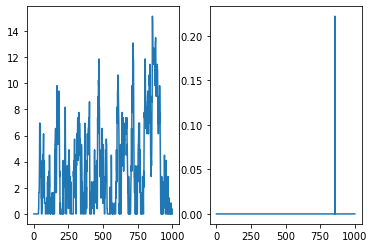

maximum steps, simulation is done ... 
elapsed_time: 50.497
Episode: 31 Exploration P: 0.5982 Total reward: -715.3776753465611 SOC: 1.0000 Cumulative_SOC_deviation: 324.7543 Fuel Consumption: 65.8690

maximum steps, simulation is done ... 
elapsed_time: 51.421
Episode: 32 Exploration P: 0.5866 Total reward: -657.2217212765047 SOC: 0.9969 Cumulative_SOC_deviation: 291.9412 Fuel Consumption: 73.3394

maximum steps, simulation is done ... 
elapsed_time: 51.026
Episode: 33 Exploration P: 0.5751 Total reward: -694.0820938370549 SOC: 1.0000 Cumulative_SOC_deviation: 314.9681 Fuel Consumption: 64.1459

maximum steps, simulation is done ... 
elapsed_time: 51.070
Episode: 34 Exploration P: 0.5639 Total reward: -701.5882862542029 SOC: 1.0000 Cumulative_SOC_deviation: 315.9920 Fuel Consumption: 69.6042

maximum steps, simulation is done ... 
elapsed_time: 51.065
Episode: 35 Exploration P: 0.5530 Total reward: -676.2017046305501 SOC: 1.0000 Cumulative_SOC_deviation: 304.1809 Fuel Consumption: 67.8

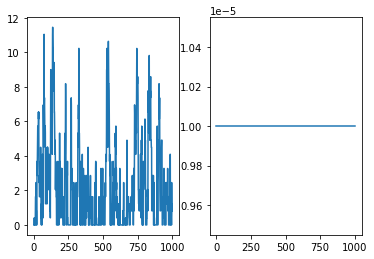

maximum steps, simulation is done ... 
elapsed_time: 50.199
Episode: 41 Exploration P: 0.4915 Total reward: -668.4381571820013 SOC: 1.0000 Cumulative_SOC_deviation: 305.5666 Fuel Consumption: 57.3050

maximum steps, simulation is done ... 
elapsed_time: 51.190
Episode: 42 Exploration P: 0.4820 Total reward: -533.5718168473712 SOC: 0.9993 Cumulative_SOC_deviation: 235.5642 Fuel Consumption: 62.4434

maximum steps, simulation is done ... 
elapsed_time: 51.229
Episode: 43 Exploration P: 0.4726 Total reward: -644.2287303409315 SOC: 1.0000 Cumulative_SOC_deviation: 294.3441 Fuel Consumption: 55.5406

maximum steps, simulation is done ... 
elapsed_time: 51.113
Episode: 44 Exploration P: 0.4634 Total reward: -649.6083890709604 SOC: 1.0000 Cumulative_SOC_deviation: 298.9840 Fuel Consumption: 51.6403

maximum steps, simulation is done ... 
elapsed_time: 51.319
Episode: 45 Exploration P: 0.4544 Total reward: -690.120415846621 SOC: 1.0000 Cumulative_SOC_deviation: 316.3406 Fuel Consumption: 57.43

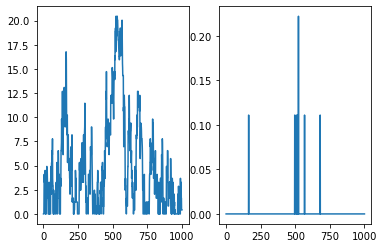

maximum steps, simulation is done ... 
elapsed_time: 50.243
Episode: 51 Exploration P: 0.4041 Total reward: -580.1709841819293 SOC: 1.0000 Cumulative_SOC_deviation: 266.1587 Fuel Consumption: 47.8536

maximum steps, simulation is done ... 
elapsed_time: 51.382
Episode: 52 Exploration P: 0.3963 Total reward: -513.3801040567115 SOC: 0.9999 Cumulative_SOC_deviation: 228.7547 Fuel Consumption: 55.8708

maximum steps, simulation is done ... 
elapsed_time: 51.396
Episode: 53 Exploration P: 0.3887 Total reward: -537.4161312763672 SOC: 0.9997 Cumulative_SOC_deviation: 245.1630 Fuel Consumption: 47.0900

maximum steps, simulation is done ... 
elapsed_time: 51.548
Episode: 54 Exploration P: 0.3812 Total reward: -490.58182031662994 SOC: 0.9914 Cumulative_SOC_deviation: 219.4862 Fuel Consumption: 51.6094

maximum steps, simulation is done ... 
elapsed_time: 51.497
Episode: 55 Exploration P: 0.3738 Total reward: -595.7782135594696 SOC: 1.0000 Cumulative_SOC_deviation: 273.4825 Fuel Consumption: 48.

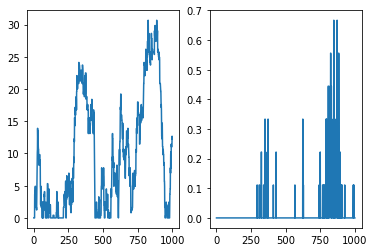

maximum steps, simulation is done ... 
elapsed_time: 50.916
Episode: 61 Exploration P: 0.3326 Total reward: -430.8730095847063 SOC: 0.9841 Cumulative_SOC_deviation: 196.1993 Fuel Consumption: 38.4744

maximum steps, simulation is done ... 
elapsed_time: 51.462
Episode: 62 Exploration P: 0.3262 Total reward: -511.0036549219526 SOC: 0.9954 Cumulative_SOC_deviation: 233.2156 Fuel Consumption: 44.5724

maximum steps, simulation is done ... 
elapsed_time: 51.282
Episode: 63 Exploration P: 0.3200 Total reward: -454.46973377259405 SOC: 0.9476 Cumulative_SOC_deviation: 203.4732 Fuel Consumption: 47.5234

maximum steps, simulation is done ... 
elapsed_time: 51.567
Episode: 64 Exploration P: 0.3138 Total reward: -460.5255804415302 SOC: 1.0000 Cumulative_SOC_deviation: 207.3265 Fuel Consumption: 45.8725

maximum steps, simulation is done ... 
elapsed_time: 51.390
Episode: 65 Exploration P: 0.3078 Total reward: -443.0052669424709 SOC: 0.9758 Cumulative_SOC_deviation: 203.1425 Fuel Consumption: 36.

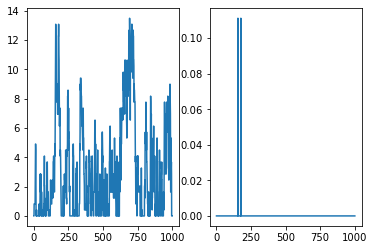

maximum steps, simulation is done ... 
elapsed_time: 50.663
Episode: 71 Exploration P: 0.2741 Total reward: -193.0267628651066 SOC: 0.7888 Cumulative_SOC_deviation: 68.9133 Fuel Consumption: 55.2001

maximum steps, simulation is done ... 
elapsed_time: 51.325
Episode: 72 Exploration P: 0.2689 Total reward: -170.60044081814866 SOC: 0.7514 Cumulative_SOC_deviation: 59.6451 Fuel Consumption: 51.3102

maximum steps, simulation is done ... 
elapsed_time: 51.457
Episode: 73 Exploration P: 0.2637 Total reward: -345.2326993175827 SOC: 0.8735 Cumulative_SOC_deviation: 151.8779 Fuel Consumption: 41.4770

maximum steps, simulation is done ... 
elapsed_time: 51.306
Episode: 74 Exploration P: 0.2587 Total reward: -377.3152476875996 SOC: 0.9210 Cumulative_SOC_deviation: 171.2571 Fuel Consumption: 34.8011

maximum steps, simulation is done ... 
elapsed_time: 51.584
Episode: 75 Exploration P: 0.2538 Total reward: -410.73651633551805 SOC: 0.9328 Cumulative_SOC_deviation: 187.1990 Fuel Consumption: 36.3

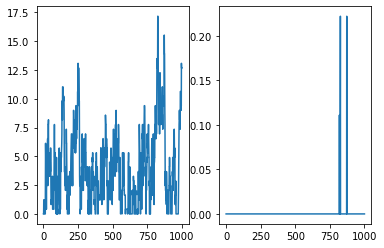

maximum steps, simulation is done ... 
elapsed_time: 50.708
Episode: 81 Exploration P: 0.2262 Total reward: -325.8540688013993 SOC: 0.8901 Cumulative_SOC_deviation: 146.3984 Fuel Consumption: 33.0574

maximum steps, simulation is done ... 
elapsed_time: 51.631
Episode: 82 Exploration P: 0.2219 Total reward: -306.81405176935056 SOC: 0.8658 Cumulative_SOC_deviation: 137.0176 Fuel Consumption: 32.7788

maximum steps, simulation is done ... 
elapsed_time: 51.749
Episode: 83 Exploration P: 0.2177 Total reward: -261.99031901627495 SOC: 0.8975 Cumulative_SOC_deviation: 113.8680 Fuel Consumption: 34.2543

maximum steps, simulation is done ... 
elapsed_time: 51.937
Episode: 84 Exploration P: 0.2136 Total reward: -347.28029918653124 SOC: 0.8980 Cumulative_SOC_deviation: 158.1433 Fuel Consumption: 30.9937

maximum steps, simulation is done ... 
elapsed_time: 51.333
Episode: 85 Exploration P: 0.2095 Total reward: -318.42297335216637 SOC: 0.8845 Cumulative_SOC_deviation: 142.6622 Fuel Consumption: 

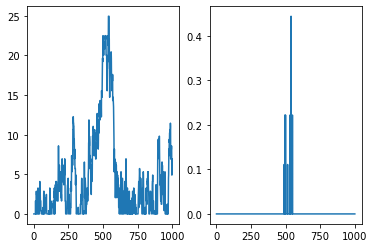

maximum steps, simulation is done ... 
elapsed_time: 50.846
Episode: 91 Exploration P: 0.1870 Total reward: -212.7360488394911 SOC: 0.7752 Cumulative_SOC_deviation: 92.5375 Fuel Consumption: 27.6610

maximum steps, simulation is done ... 
elapsed_time: 51.489
Episode: 92 Exploration P: 0.1834 Total reward: -158.8075242276531 SOC: 0.6703 Cumulative_SOC_deviation: 61.4202 Fuel Consumption: 35.9671

maximum steps, simulation is done ... 
elapsed_time: 51.888
Episode: 93 Exploration P: 0.1800 Total reward: -332.01219461744887 SOC: 0.8489 Cumulative_SOC_deviation: 152.1808 Fuel Consumption: 27.6507

maximum steps, simulation is done ... 
elapsed_time: 51.596
Episode: 94 Exploration P: 0.1766 Total reward: -209.14748248318034 SOC: 0.8077 Cumulative_SOC_deviation: 91.9402 Fuel Consumption: 25.2672

maximum steps, simulation is done ... 
elapsed_time: 51.738
Episode: 95 Exploration P: 0.1733 Total reward: -227.1882170351353 SOC: 0.8315 Cumulative_SOC_deviation: 99.3199 Fuel Consumption: 28.548

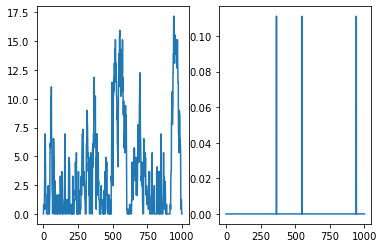

maximum steps, simulation is done ... 
elapsed_time: 51.270
Episode: 101 Exploration P: 0.1559 Total reward: -167.61617110706996 SOC: 0.7683 Cumulative_SOC_deviation: 70.6844 Fuel Consumption: 26.2474

maximum steps, simulation is done ... 
elapsed_time: 51.371
Episode: 102 Exploration P: 0.1530 Total reward: -174.10081629426668 SOC: 0.7527 Cumulative_SOC_deviation: 75.7943 Fuel Consumption: 22.5122

maximum steps, simulation is done ... 
elapsed_time: 51.911
Episode: 103 Exploration P: 0.1502 Total reward: -153.45442530697883 SOC: 0.7125 Cumulative_SOC_deviation: 66.4874 Fuel Consumption: 20.4796

maximum steps, simulation is done ... 
elapsed_time: 51.880
Episode: 104 Exploration P: 0.1474 Total reward: -190.8884032885299 SOC: 0.7580 Cumulative_SOC_deviation: 85.7152 Fuel Consumption: 19.4581

maximum steps, simulation is done ... 
elapsed_time: 51.986
Episode: 105 Exploration P: 0.1447 Total reward: -115.3180672107891 SOC: 0.6711 Cumulative_SOC_deviation: 48.0332 Fuel Consumption: 1

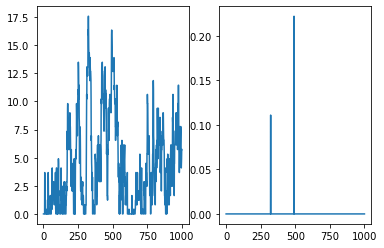

maximum steps, simulation is done ... 
elapsed_time: 51.268
Episode: 111 Exploration P: 0.1294 Total reward: -116.84156252705704 SOC: 0.6724 Cumulative_SOC_deviation: 48.7279 Fuel Consumption: 19.3858

maximum steps, simulation is done ... 
elapsed_time: 51.059
Episode: 112 Exploration P: 0.1271 Total reward: -119.76989939003613 SOC: 0.7074 Cumulative_SOC_deviation: 50.9040 Fuel Consumption: 17.9619

maximum steps, simulation is done ... 
elapsed_time: 51.799
Episode: 113 Exploration P: 0.1248 Total reward: -166.51939133425813 SOC: 0.7109 Cumulative_SOC_deviation: 74.0053 Fuel Consumption: 18.5088

maximum steps, simulation is done ... 
elapsed_time: 51.810
Episode: 114 Exploration P: 0.1225 Total reward: -137.06328378068775 SOC: 0.7055 Cumulative_SOC_deviation: 59.6023 Fuel Consumption: 17.8587

maximum steps, simulation is done ... 
elapsed_time: 51.961
Episode: 115 Exploration P: 0.1202 Total reward: -185.1127943076962 SOC: 0.7439 Cumulative_SOC_deviation: 81.7440 Fuel Consumption: 

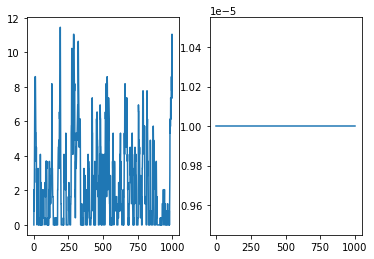

maximum steps, simulation is done ... 
elapsed_time: 51.805
Episode: 121 Exploration P: 0.1078 Total reward: -114.48010330314938 SOC: 0.6971 Cumulative_SOC_deviation: 49.7655 Fuel Consumption: 14.9490

maximum steps, simulation is done ... 
elapsed_time: 51.277
Episode: 122 Exploration P: 0.1058 Total reward: -112.24201002387466 SOC: 0.7039 Cumulative_SOC_deviation: 47.5373 Fuel Consumption: 17.1674

maximum steps, simulation is done ... 
elapsed_time: 52.162
Episode: 123 Exploration P: 0.1039 Total reward: -113.8372196257417 SOC: 0.6879 Cumulative_SOC_deviation: 49.6040 Fuel Consumption: 14.6292

maximum steps, simulation is done ... 
elapsed_time: 51.759
Episode: 124 Exploration P: 0.1021 Total reward: -117.38373976973412 SOC: 0.7108 Cumulative_SOC_deviation: 51.3102 Fuel Consumption: 14.7633

maximum steps, simulation is done ... 
elapsed_time: 52.174
Episode: 125 Exploration P: 0.1002 Total reward: -87.11844203086669 SOC: 0.6165 Cumulative_SOC_deviation: 36.5439 Fuel Consumption: 1

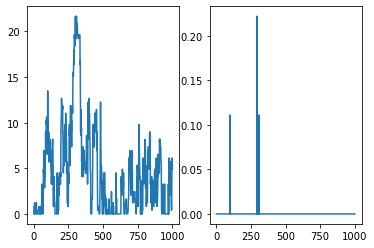

maximum steps, simulation is done ... 
elapsed_time: 51.629
Episode: 131 Exploration P: 0.0900 Total reward: -65.2202330965531 SOC: 0.5786 Cumulative_SOC_deviation: 24.6610 Fuel Consumption: 15.8983

maximum steps, simulation is done ... 
elapsed_time: 51.488
Episode: 132 Exploration P: 0.0884 Total reward: -47.198307796883206 SOC: 0.6358 Cumulative_SOC_deviation: 16.2175 Fuel Consumption: 14.7633

maximum steps, simulation is done ... 
elapsed_time: 51.724
Episode: 133 Exploration P: 0.0869 Total reward: -44.83268296522167 SOC: 0.6249 Cumulative_SOC_deviation: 16.2677 Fuel Consumption: 12.2973

maximum steps, simulation is done ... 
elapsed_time: 51.846
Episode: 134 Exploration P: 0.0854 Total reward: -91.60617323334618 SOC: 0.6349 Cumulative_SOC_deviation: 39.5513 Fuel Consumption: 12.5036

maximum steps, simulation is done ... 
elapsed_time: 51.812
Episode: 135 Exploration P: 0.0839 Total reward: -50.28872224017277 SOC: 0.5587 Cumulative_SOC_deviation: 18.7326 Fuel Consumption: 12.8

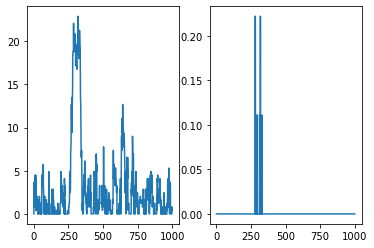

maximum steps, simulation is done ... 
elapsed_time: 52.005
Episode: 141 Exploration P: 0.0755 Total reward: -71.54660009039658 SOC: 0.6516 Cumulative_SOC_deviation: 30.3418 Fuel Consumption: 10.8630

maximum steps, simulation is done ... 
elapsed_time: 51.739
Episode: 142 Exploration P: 0.0742 Total reward: -44.82721401505358 SOC: 0.5553 Cumulative_SOC_deviation: 16.5694 Fuel Consumption: 11.6885

maximum steps, simulation is done ... 
elapsed_time: 51.163
Episode: 143 Exploration P: 0.0729 Total reward: -35.215330837330804 SOC: 0.5783 Cumulative_SOC_deviation: 12.2123 Fuel Consumption: 10.7908

maximum steps, simulation is done ... 
elapsed_time: 51.956
Episode: 144 Exploration P: 0.0717 Total reward: -42.17678579786915 SOC: 0.5886 Cumulative_SOC_deviation: 15.3989 Fuel Consumption: 11.3790

maximum steps, simulation is done ... 
elapsed_time: 51.990
Episode: 145 Exploration P: 0.0705 Total reward: -64.4328005706922 SOC: 0.6290 Cumulative_SOC_deviation: 25.4951 Fuel Consumption: 13.4

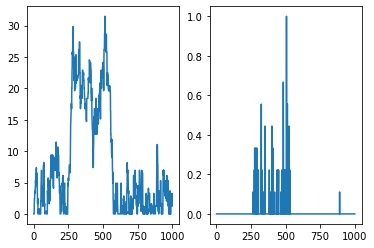

maximum steps, simulation is done ... 
elapsed_time: 52.159
Episode: 151 Exploration P: 0.0636 Total reward: -76.47226737131608 SOC: 0.5549 Cumulative_SOC_deviation: 33.4908 Fuel Consumption: 9.4907

maximum steps, simulation is done ... 
elapsed_time: 52.152
Episode: 152 Exploration P: 0.0626 Total reward: -27.42295039611584 SOC: 0.6207 Cumulative_SOC_deviation: 8.8681 Fuel Consumption: 9.6868

maximum steps, simulation is done ... 
elapsed_time: 51.634
Episode: 153 Exploration P: 0.0615 Total reward: -28.3282460292201 SOC: 0.5858 Cumulative_SOC_deviation: 10.2442 Fuel Consumption: 7.8398

maximum steps, simulation is done ... 
elapsed_time: 51.988
Episode: 154 Exploration P: 0.0605 Total reward: -39.11243947459087 SOC: 0.5335 Cumulative_SOC_deviation: 15.7498 Fuel Consumption: 7.6128

maximum steps, simulation is done ... 
elapsed_time: 52.307
Episode: 155 Exploration P: 0.0595 Total reward: -131.29859401807036 SOC: 0.4973 Cumulative_SOC_deviation: 61.4095 Fuel Consumption: 8.4796

m

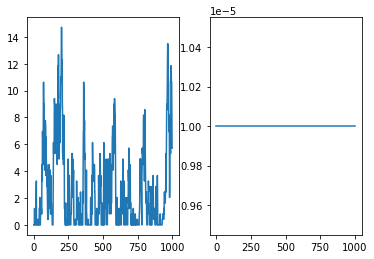

maximum steps, simulation is done ... 
elapsed_time: 52.093
Episode: 161 Exploration P: 0.0539 Total reward: -111.67185533692961 SOC: 0.4632 Cumulative_SOC_deviation: 51.8231 Fuel Consumption: 8.0256

maximum steps, simulation is done ... 
elapsed_time: 51.720
Episode: 162 Exploration P: 0.0530 Total reward: -62.0352220846499 SOC: 0.5440 Cumulative_SOC_deviation: 27.6136 Fuel Consumption: 6.8080

maximum steps, simulation is done ... 
elapsed_time: 51.317
Episode: 163 Exploration P: 0.0522 Total reward: -27.162328153555404 SOC: 0.6039 Cumulative_SOC_deviation: 9.2227 Fuel Consumption: 8.7169

maximum steps, simulation is done ... 
elapsed_time: 52.127
Episode: 164 Exploration P: 0.0513 Total reward: -67.52858803287994 SOC: 0.5622 Cumulative_SOC_deviation: 30.1849 Fuel Consumption: 7.1588

maximum steps, simulation is done ... 
elapsed_time: 51.916
Episode: 165 Exploration P: 0.0505 Total reward: -96.09875203201794 SOC: 0.4401 Cumulative_SOC_deviation: 43.0976 Fuel Consumption: 9.9035



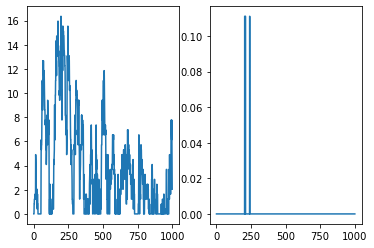

maximum steps, simulation is done ... 
elapsed_time: 55.238
Episode: 171 Exploration P: 0.0459 Total reward: -195.3432942058106 SOC: 0.3379 Cumulative_SOC_deviation: 92.6116 Fuel Consumption: 10.1201

maximum steps, simulation is done ... 
elapsed_time: 54.979
Episode: 172 Exploration P: 0.0452 Total reward: -54.129994503071565 SOC: 0.5338 Cumulative_SOC_deviation: 23.5217 Fuel Consumption: 7.0866

maximum steps, simulation is done ... 
elapsed_time: 53.687
Episode: 173 Exploration P: 0.0445 Total reward: -110.83096488875303 SOC: 0.4250 Cumulative_SOC_deviation: 51.0467 Fuel Consumption: 8.7375

maximum steps, simulation is done ... 
elapsed_time: 51.977
Episode: 174 Exploration P: 0.0438 Total reward: -31.927302385328638 SOC: 0.5510 Cumulative_SOC_deviation: 13.1013 Fuel Consumption: 5.7246

maximum steps, simulation is done ... 
elapsed_time: 52.216
Episode: 175 Exploration P: 0.0432 Total reward: -46.49973234062662 SOC: 0.5669 Cumulative_SOC_deviation: 20.4959 Fuel Consumption: 5.50

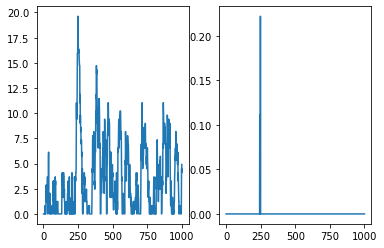

maximum steps, simulation is done ... 
elapsed_time: 52.009
Episode: 181 Exploration P: 0.0394 Total reward: -70.83437546093037 SOC: 0.5317 Cumulative_SOC_deviation: 32.6942 Fuel Consumption: 5.4460

maximum steps, simulation is done ... 
elapsed_time: 51.863
Episode: 182 Exploration P: 0.0388 Total reward: -33.98694675813069 SOC: 0.5798 Cumulative_SOC_deviation: 14.3943 Fuel Consumption: 5.1984

maximum steps, simulation is done ... 
elapsed_time: 51.147
Episode: 183 Exploration P: 0.0383 Total reward: -99.87463876802143 SOC: 0.5314 Cumulative_SOC_deviation: 46.6468 Fuel Consumption: 6.5810

maximum steps, simulation is done ... 
elapsed_time: 51.975
Episode: 184 Exploration P: 0.0377 Total reward: -27.221567895694232 SOC: 0.5759 Cumulative_SOC_deviation: 9.7373 Fuel Consumption: 7.7470

maximum steps, simulation is done ... 
elapsed_time: 51.962
Episode: 185 Exploration P: 0.0371 Total reward: -88.01764147361226 SOC: 0.5261 Cumulative_SOC_deviation: 41.4303 Fuel Consumption: 5.1571



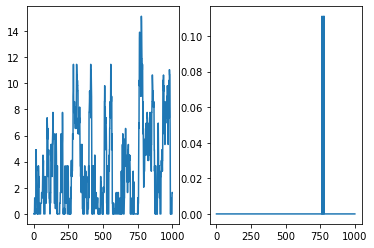

maximum steps, simulation is done ... 
elapsed_time: 52.239
Episode: 191 Exploration P: 0.0341 Total reward: -63.95018380387361 SOC: 0.5424 Cumulative_SOC_deviation: 29.1179 Fuel Consumption: 5.7143

maximum steps, simulation is done ... 
elapsed_time: 51.961
Episode: 192 Exploration P: 0.0336 Total reward: -128.30617335287505 SOC: 0.4944 Cumulative_SOC_deviation: 61.4094 Fuel Consumption: 5.4873

maximum steps, simulation is done ... 
elapsed_time: 52.278
Episode: 193 Exploration P: 0.0331 Total reward: -35.449955960648154 SOC: 0.4984 Cumulative_SOC_deviation: 14.5583 Fuel Consumption: 6.3334

maximum steps, simulation is done ... 
elapsed_time: 51.258
Episode: 194 Exploration P: 0.0327 Total reward: -65.59957219203883 SOC: 0.5455 Cumulative_SOC_deviation: 30.9796 Fuel Consumption: 3.6404

maximum steps, simulation is done ... 
elapsed_time: 52.383
Episode: 195 Exploration P: 0.0322 Total reward: -86.5419267718698 SOC: 0.5160 Cumulative_SOC_deviation: 40.3932 Fuel Consumption: 5.7556


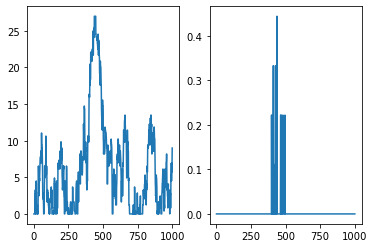

maximum steps, simulation is done ... 
elapsed_time: 52.009
Episode: 201 Exploration P: 0.0297 Total reward: -98.84211669810325 SOC: 0.5223 Cumulative_SOC_deviation: 47.5338 Fuel Consumption: 3.7745

maximum steps, simulation is done ... 
elapsed_time: 51.948
Episode: 202 Exploration P: 0.0293 Total reward: -62.57975972710579 SOC: 0.5513 Cumulative_SOC_deviation: 29.3407 Fuel Consumption: 3.8983

maximum steps, simulation is done ... 
elapsed_time: 52.122
Episode: 203 Exploration P: 0.0289 Total reward: -107.58227198993876 SOC: 0.5036 Cumulative_SOC_deviation: 51.6821 Fuel Consumption: 4.2182

maximum steps, simulation is done ... 
elapsed_time: 51.277
Episode: 204 Exploration P: 0.0286 Total reward: -96.09528869418438 SOC: 0.5245 Cumulative_SOC_deviation: 46.5938 Fuel Consumption: 2.9078

maximum steps, simulation is done ... 
elapsed_time: 51.937
Episode: 205 Exploration P: 0.0282 Total reward: -150.149869295034 SOC: 0.4727 Cumulative_SOC_deviation: 72.7595 Fuel Consumption: 4.6309



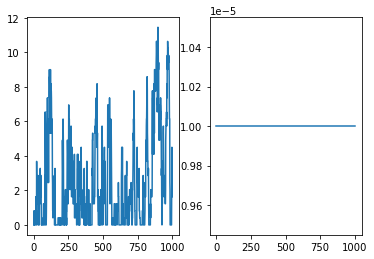

maximum steps, simulation is done ... 
elapsed_time: 52.146
Episode: 211 Exploration P: 0.0261 Total reward: -176.43097927438538 SOC: 0.4796 Cumulative_SOC_deviation: 85.8897 Fuel Consumption: 4.6515

maximum steps, simulation is done ... 
elapsed_time: 52.168
Episode: 212 Exploration P: 0.0258 Total reward: -78.74051408536256 SOC: 0.5419 Cumulative_SOC_deviation: 36.7195 Fuel Consumption: 5.3016

maximum steps, simulation is done ... 
elapsed_time: 52.187
Episode: 213 Exploration P: 0.0255 Total reward: -84.96069991049079 SOC: 0.5017 Cumulative_SOC_deviation: 40.9904 Fuel Consumption: 2.9800

maximum steps, simulation is done ... 
elapsed_time: 51.405
Episode: 214 Exploration P: 0.0252 Total reward: -95.5169429849306 SOC: 0.5030 Cumulative_SOC_deviation: 46.1034 Fuel Consumption: 3.3102

maximum steps, simulation is done ... 
elapsed_time: 51.625
Episode: 215 Exploration P: 0.0249 Total reward: -96.08467661857657 SOC: 0.5050 Cumulative_SOC_deviation: 45.7991 Fuel Consumption: 4.4864



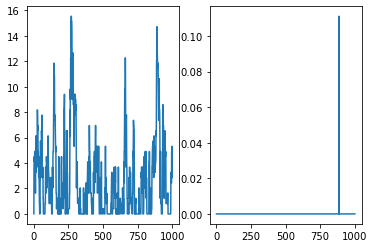

maximum steps, simulation is done ... 
elapsed_time: 52.176
Episode: 221 Exploration P: 0.0232 Total reward: -71.54380321082269 SOC: 0.5399 Cumulative_SOC_deviation: 33.9930 Fuel Consumption: 3.5578

maximum steps, simulation is done ... 
elapsed_time: 52.220
Episode: 222 Exploration P: 0.0229 Total reward: -246.79145787647178 SOC: 0.4163 Cumulative_SOC_deviation: 121.3898 Fuel Consumption: 4.0118

maximum steps, simulation is done ... 
elapsed_time: 52.038
Episode: 223 Exploration P: 0.0227 Total reward: -105.08946652609495 SOC: 0.5005 Cumulative_SOC_deviation: 50.8329 Fuel Consumption: 3.4237

maximum steps, simulation is done ... 
elapsed_time: 51.394
Episode: 224 Exploration P: 0.0224 Total reward: -58.4372831284874 SOC: 0.5412 Cumulative_SOC_deviation: 27.0167 Fuel Consumption: 4.4039

maximum steps, simulation is done ... 
elapsed_time: 52.072
Episode: 225 Exploration P: 0.0222 Total reward: -83.35182663311207 SOC: 0.5022 Cumulative_SOC_deviation: 39.8970 Fuel Consumption: 3.5578

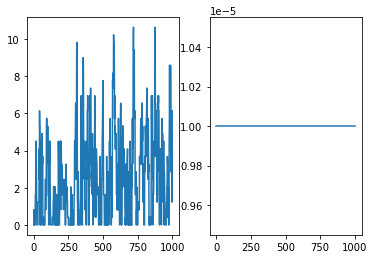

maximum steps, simulation is done ... 
elapsed_time: 52.055
Episode: 231 Exploration P: 0.0208 Total reward: -80.61863403929365 SOC: 0.4821 Cumulative_SOC_deviation: 38.3653 Fuel Consumption: 3.8880

maximum steps, simulation is done ... 
elapsed_time: 51.798
Episode: 232 Exploration P: 0.0206 Total reward: -160.93722424905732 SOC: 0.4244 Cumulative_SOC_deviation: 78.0139 Fuel Consumption: 4.9095

maximum steps, simulation is done ... 
elapsed_time: 52.032
Episode: 233 Exploration P: 0.0204 Total reward: -234.64421469052743 SOC: 0.3648 Cumulative_SOC_deviation: 113.5828 Fuel Consumption: 7.4787

maximum steps, simulation is done ... 
elapsed_time: 51.619
Episode: 234 Exploration P: 0.0202 Total reward: -127.22306571558221 SOC: 0.4987 Cumulative_SOC_deviation: 62.3692 Fuel Consumption: 2.4847

maximum steps, simulation is done ... 
elapsed_time: 51.879
Episode: 235 Exploration P: 0.0200 Total reward: -301.46261879481693 SOC: 0.4115 Cumulative_SOC_deviation: 147.7400 Fuel Consumption: 5.

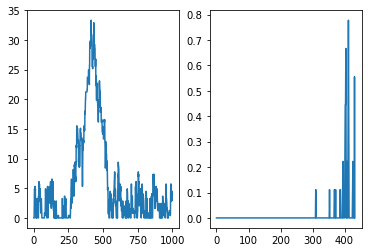

maximum steps, simulation is done ... 
elapsed_time: 52.235
Episode: 241 Exploration P: 0.0189 Total reward: -86.42524390446779 SOC: 0.5324 Cumulative_SOC_deviation: 42.0373 Fuel Consumption: 2.3506

maximum steps, simulation is done ... 
elapsed_time: 52.501
Episode: 242 Exploration P: 0.0188 Total reward: -93.65241319843244 SOC: 0.5205 Cumulative_SOC_deviation: 45.2795 Fuel Consumption: 3.0935

maximum steps, simulation is done ... 
elapsed_time: 52.062
Episode: 243 Exploration P: 0.0186 Total reward: -126.37890995310715 SOC: 0.4945 Cumulative_SOC_deviation: 61.7046 Fuel Consumption: 2.9697

maximum steps, simulation is done ... 
elapsed_time: 52.149
Episode: 244 Exploration P: 0.0184 Total reward: -76.0046116128683 SOC: 0.5115 Cumulative_SOC_deviation: 36.4143 Fuel Consumption: 3.1760

maximum steps, simulation is done ... 
elapsed_time: 51.450
Episode: 245 Exploration P: 0.0183 Total reward: -78.3369375816168 SOC: 0.5076 Cumulative_SOC_deviation: 38.2253 Fuel Consumption: 1.8863

m

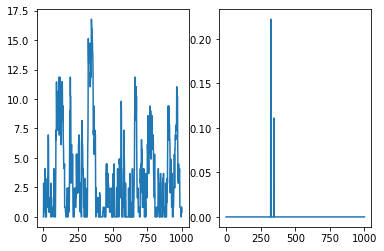

maximum steps, simulation is done ... 
elapsed_time: 52.115
Episode: 251 Exploration P: 0.0173 Total reward: -107.59778593478829 SOC: 0.4961 Cumulative_SOC_deviation: 52.5514 Fuel Consumption: 2.4950

maximum steps, simulation is done ... 
elapsed_time: 52.270
Episode: 252 Exploration P: 0.0172 Total reward: -136.2640823800497 SOC: 0.4898 Cumulative_SOC_deviation: 66.8278 Fuel Consumption: 2.6085

maximum steps, simulation is done ... 
elapsed_time: 52.066
Episode: 253 Exploration P: 0.0170 Total reward: -184.92470443526355 SOC: 0.4456 Cumulative_SOC_deviation: 91.1220 Fuel Consumption: 2.6808

maximum steps, simulation is done ... 
elapsed_time: 51.900
Episode: 254 Exploration P: 0.0169 Total reward: -321.39034211062756 SOC: 0.2951 Cumulative_SOC_deviation: 158.0857 Fuel Consumption: 5.2190

maximum steps, simulation is done ... 
elapsed_time: 51.781
Episode: 255 Exploration P: 0.0168 Total reward: -116.01635660650336 SOC: 0.4616 Cumulative_SOC_deviation: 56.9412 Fuel Consumption: 2.1

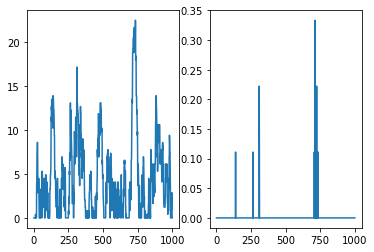

maximum steps, simulation is done ... 
elapsed_time: 52.606
Episode: 261 Exploration P: 0.0160 Total reward: -59.09784136704324 SOC: 0.5446 Cumulative_SOC_deviation: 28.3169 Fuel Consumption: 2.4641

maximum steps, simulation is done ... 
elapsed_time: 52.019
Episode: 262 Exploration P: 0.0159 Total reward: -106.56522931324338 SOC: 0.5079 Cumulative_SOC_deviation: 51.5708 Fuel Consumption: 3.4237

maximum steps, simulation is done ... 
elapsed_time: 52.436
Episode: 263 Exploration P: 0.0158 Total reward: -92.26920381943513 SOC: 0.5206 Cumulative_SOC_deviation: 45.6816 Fuel Consumption: 0.9060

maximum steps, simulation is done ... 
elapsed_time: 52.300
Episode: 264 Exploration P: 0.0156 Total reward: -84.77353796406994 SOC: 0.5291 Cumulative_SOC_deviation: 41.0670 Fuel Consumption: 2.6395

maximum steps, simulation is done ... 
elapsed_time: 52.375
Episode: 265 Exploration P: 0.0155 Total reward: -207.37545165249813 SOC: 0.4078 Cumulative_SOC_deviation: 102.5228 Fuel Consumption: 2.329

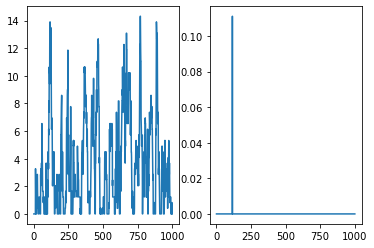

maximum steps, simulation is done ... 
elapsed_time: 52.323
Episode: 271 Exploration P: 0.0149 Total reward: -86.29119643815977 SOC: 0.5073 Cumulative_SOC_deviation: 42.0632 Fuel Consumption: 2.1649

maximum steps, simulation is done ... 
elapsed_time: 52.126
Episode: 272 Exploration P: 0.0148 Total reward: -199.85521695886814 SOC: 0.4251 Cumulative_SOC_deviation: 99.0825 Fuel Consumption: 1.6902

maximum steps, simulation is done ... 
elapsed_time: 52.351
Episode: 273 Exploration P: 0.0147 Total reward: -101.41301894673359 SOC: 0.5119 Cumulative_SOC_deviation: 49.7634 Fuel Consumption: 1.8863

maximum steps, simulation is done ... 
elapsed_time: 52.120
Episode: 274 Exploration P: 0.0146 Total reward: -43.77710360045705 SOC: 0.5344 Cumulative_SOC_deviation: 20.4811 Fuel Consumption: 2.8149

maximum steps, simulation is done ... 
elapsed_time: 52.101
Episode: 275 Exploration P: 0.0145 Total reward: -378.15841878618716 SOC: 0.3357 Cumulative_SOC_deviation: 186.6193 Fuel Consumption: 4.91

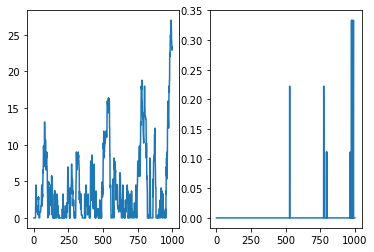

maximum steps, simulation is done ... 
elapsed_time: 52.008
Episode: 281 Exploration P: 0.0140 Total reward: -98.93904915420401 SOC: 0.5077 Cumulative_SOC_deviation: 48.4232 Fuel Consumption: 2.0926

maximum steps, simulation is done ... 
elapsed_time: 52.119
Episode: 282 Exploration P: 0.0139 Total reward: -146.15892791364172 SOC: 0.4792 Cumulative_SOC_deviation: 72.6780 Fuel Consumption: 0.8029

maximum steps, simulation is done ... 
elapsed_time: 51.958
Episode: 283 Exploration P: 0.0139 Total reward: -127.28221936765462 SOC: 0.4876 Cumulative_SOC_deviation: 62.3317 Fuel Consumption: 2.6189

maximum steps, simulation is done ... 
elapsed_time: 51.889
Episode: 284 Exploration P: 0.0138 Total reward: -175.90514866531544 SOC: 0.4590 Cumulative_SOC_deviation: 87.1436 Fuel Consumption: 1.6180

maximum steps, simulation is done ... 
elapsed_time: 51.753
Episode: 285 Exploration P: 0.0137 Total reward: -115.87810763821128 SOC: 0.4904 Cumulative_SOC_deviation: 56.9443 Fuel Consumption: 1.98

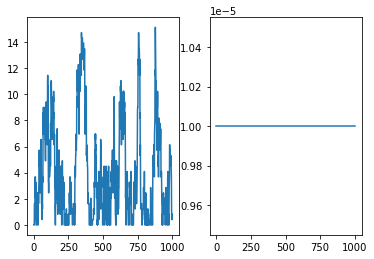

maximum steps, simulation is done ... 
elapsed_time: 51.981
Episode: 291 Exploration P: 0.0133 Total reward: -64.63585136899663 SOC: 0.5309 Cumulative_SOC_deviation: 31.0910 Fuel Consumption: 2.4538

maximum steps, simulation is done ... 
elapsed_time: 51.879
Episode: 292 Exploration P: 0.0132 Total reward: -119.97300596909628 SOC: 0.4521 Cumulative_SOC_deviation: 58.4759 Fuel Consumption: 3.0213

maximum steps, simulation is done ... 
elapsed_time: 52.251
Episode: 293 Exploration P: 0.0132 Total reward: -202.25002063202498 SOC: 0.4221 Cumulative_SOC_deviation: 99.8981 Fuel Consumption: 2.4538

maximum steps, simulation is done ... 
elapsed_time: 52.186
Episode: 294 Exploration P: 0.0131 Total reward: -84.8140887353449 SOC: 0.5174 Cumulative_SOC_deviation: 41.4226 Fuel Consumption: 1.9688

maximum steps, simulation is done ... 
elapsed_time: 52.015
Episode: 295 Exploration P: 0.0130 Total reward: -159.32486384659418 SOC: 0.4344 Cumulative_SOC_deviation: 78.7606 Fuel Consumption: 1.8037

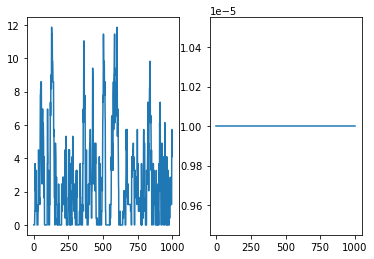

maximum steps, simulation is done ... 
elapsed_time: 51.617
Episode: 301 Exploration P: 0.0127 Total reward: -117.68085056749874 SOC: 0.4885 Cumulative_SOC_deviation: 57.6651 Fuel Consumption: 2.3506

maximum steps, simulation is done ... 
elapsed_time: 51.733
Episode: 302 Exploration P: 0.0126 Total reward: -144.82138648385995 SOC: 0.4867 Cumulative_SOC_deviation: 71.3076 Fuel Consumption: 2.2061

maximum steps, simulation is done ... 
elapsed_time: 51.753
Episode: 303 Exploration P: 0.0126 Total reward: -473.113114928336 SOC: 0.1311 Cumulative_SOC_deviation: 228.0760 Fuel Consumption: 16.9611

maximum steps, simulation is done ... 
elapsed_time: 51.663
Episode: 304 Exploration P: 0.0125 Total reward: -175.46947076751744 SOC: 0.4107 Cumulative_SOC_deviation: 86.3376 Fuel Consumption: 2.7943

battery power is 112060.32985827675(+) but condition is not avail
elapsed_time: 47.485
Episode: 305 Exploration P: 0.0125 Total reward: -1142.8034988302215 SOC: 0.3714 Cumulative_SOC_deviation: 69

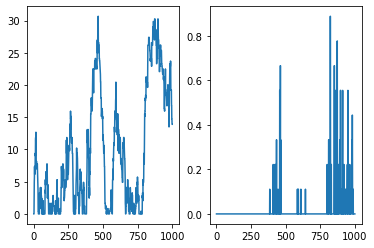

maximum steps, simulation is done ... 
elapsed_time: 52.175
Episode: 311 Exploration P: 0.0122 Total reward: -161.47742635210028 SOC: 0.3975 Cumulative_SOC_deviation: 78.7638 Fuel Consumption: 3.9499

maximum steps, simulation is done ... 
elapsed_time: 52.088
Episode: 312 Exploration P: 0.0122 Total reward: -410.0264402630305 SOC: 0.3086 Cumulative_SOC_deviation: 202.4243 Fuel Consumption: 5.1778

maximum steps, simulation is done ... 
elapsed_time: 52.191
Episode: 313 Exploration P: 0.0121 Total reward: -91.60899940852138 SOC: 0.4981 Cumulative_SOC_deviation: 45.2431 Fuel Consumption: 1.1227

maximum steps, simulation is done ... 
elapsed_time: 51.956
Episode: 314 Exploration P: 0.0121 Total reward: -169.07665202380275 SOC: 0.3653 Cumulative_SOC_deviation: 82.1610 Fuel Consumption: 4.7547

maximum steps, simulation is done ... 
elapsed_time: 51.803
Episode: 315 Exploration P: 0.0120 Total reward: -70.65899000812011 SOC: 0.5285 Cumulative_SOC_deviation: 34.5205 Fuel Consumption: 1.618

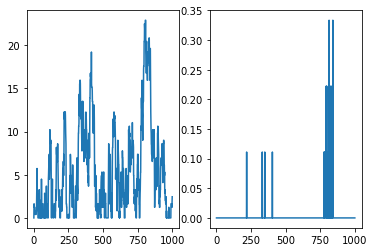

maximum steps, simulation is done ... 
elapsed_time: 51.953
Episode: 321 Exploration P: 0.0118 Total reward: -814.0518713177486 SOC: -0.0106 Cumulative_SOC_deviation: 394.3820 Fuel Consumption: 25.2878

maximum steps, simulation is done ... 
elapsed_time: 51.742
Episode: 322 Exploration P: 0.0118 Total reward: -205.40479497524674 SOC: 0.4447 Cumulative_SOC_deviation: 101.8779 Fuel Consumption: 1.6490

maximum steps, simulation is done ... 
elapsed_time: 51.911
Episode: 323 Exploration P: 0.0118 Total reward: -104.38995884328355 SOC: 0.5116 Cumulative_SOC_deviation: 51.1693 Fuel Consumption: 2.0514

maximum steps, simulation is done ... 
elapsed_time: 52.024
Episode: 324 Exploration P: 0.0117 Total reward: -70.62222494193682 SOC: 0.4934 Cumulative_SOC_deviation: 34.1771 Fuel Consumption: 2.2680

maximum steps, simulation is done ... 
elapsed_time: 52.162
Episode: 325 Exploration P: 0.0117 Total reward: -141.52267411036814 SOC: 0.4412 Cumulative_SOC_deviation: 70.0039 Fuel Consumption: 1

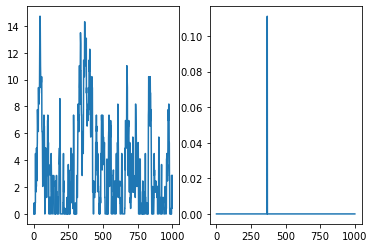

maximum steps, simulation is done ... 
elapsed_time: 51.851
Episode: 331 Exploration P: 0.0115 Total reward: -162.64378484213142 SOC: 0.4598 Cumulative_SOC_deviation: 80.5851 Fuel Consumption: 1.4735

maximum steps, simulation is done ... 
elapsed_time: 52.125
Episode: 332 Exploration P: 0.0115 Total reward: -99.71632878043943 SOC: 0.3726 Cumulative_SOC_deviation: 47.5582 Fuel Consumption: 4.5999

maximum steps, simulation is done ... 
elapsed_time: 52.036
Episode: 333 Exploration P: 0.0114 Total reward: -136.60667402610443 SOC: 0.4927 Cumulative_SOC_deviation: 67.6285 Fuel Consumption: 1.3497

maximum steps, simulation is done ... 
elapsed_time: 51.993
Episode: 334 Exploration P: 0.0114 Total reward: -436.4712389246636 SOC: 0.2070 Cumulative_SOC_deviation: 212.1747 Fuel Consumption: 12.1219

maximum steps, simulation is done ... 
elapsed_time: 52.162
Episode: 335 Exploration P: 0.0114 Total reward: -70.85544741180173 SOC: 0.5160 Cumulative_SOC_deviation: 35.0985 Fuel Consumption: 0.65

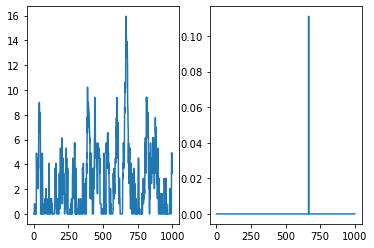

maximum steps, simulation is done ... 
elapsed_time: 51.968
Episode: 341 Exploration P: 0.0112 Total reward: -64.20979688538178 SOC: 0.5448 Cumulative_SOC_deviation: 31.0792 Fuel Consumption: 2.0514

maximum steps, simulation is done ... 
elapsed_time: 52.157
Episode: 342 Exploration P: 0.0112 Total reward: -155.06684325914273 SOC: 0.3788 Cumulative_SOC_deviation: 76.6212 Fuel Consumption: 1.8244

maximum steps, simulation is done ... 
elapsed_time: 52.039
Episode: 343 Exploration P: 0.0112 Total reward: -184.4825925789873 SOC: 0.3942 Cumulative_SOC_deviation: 91.2105 Fuel Consumption: 2.0617

battery power is 115471.32750186794(+) but condition is not avail
elapsed_time: 15.821
Episode: 344 Exploration P: 0.0112 Total reward: -1018.0879972435773 SOC: 0.4489 Cumulative_SOC_deviation: 7.4603 Fuel Consumption: 3.4694

maximum steps, simulation is done ... 
elapsed_time: 51.997
Episode: 345 Exploration P: 0.0112 Total reward: -182.54686322507206 SOC: 0.4523 Cumulative_SOC_deviation: 90.12

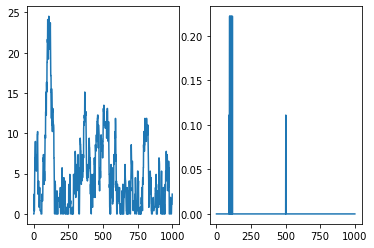

maximum steps, simulation is done ... 
elapsed_time: 51.331
Episode: 351 Exploration P: 0.0110 Total reward: -160.4098030901263 SOC: 0.4448 Cumulative_SOC_deviation: 79.8602 Fuel Consumption: 0.6894

maximum steps, simulation is done ... 
elapsed_time: 51.963
Episode: 352 Exploration P: 0.0110 Total reward: -275.6669645055813 SOC: 0.4007 Cumulative_SOC_deviation: 136.5499 Fuel Consumption: 2.5673

maximum steps, simulation is done ... 
elapsed_time: 52.255
Episode: 353 Exploration P: 0.0110 Total reward: -118.45557974986859 SOC: 0.3949 Cumulative_SOC_deviation: 56.8969 Fuel Consumption: 4.6618

maximum steps, simulation is done ... 
elapsed_time: 51.900
Episode: 354 Exploration P: 0.0110 Total reward: -164.45263364048537 SOC: 0.4194 Cumulative_SOC_deviation: 81.1542 Fuel Consumption: 2.1442

maximum steps, simulation is done ... 
elapsed_time: 51.683
Episode: 355 Exploration P: 0.0109 Total reward: -106.04192255469167 SOC: 0.4790 Cumulative_SOC_deviation: 51.7270 Fuel Consumption: 2.58

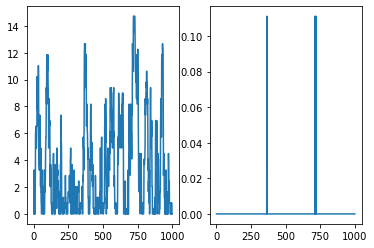

maximum steps, simulation is done ... 
elapsed_time: 51.165
Episode: 361 Exploration P: 0.0108 Total reward: -135.7314523017242 SOC: 0.4725 Cumulative_SOC_deviation: 67.0722 Fuel Consumption: 1.5870

maximum steps, simulation is done ... 
elapsed_time: 52.028
Episode: 362 Exploration P: 0.0108 Total reward: -175.47602729354858 SOC: 0.4520 Cumulative_SOC_deviation: 87.0322 Fuel Consumption: 1.4116

maximum steps, simulation is done ... 
elapsed_time: 52.185
Episode: 363 Exploration P: 0.0108 Total reward: -146.45730030584684 SOC: 0.4678 Cumulative_SOC_deviation: 72.7344 Fuel Consumption: 0.9886

maximum steps, simulation is done ... 
elapsed_time: 51.885
Episode: 364 Exploration P: 0.0108 Total reward: -276.79788340552346 SOC: 0.3262 Cumulative_SOC_deviation: 136.3311 Fuel Consumption: 4.1356

maximum steps, simulation is done ... 
elapsed_time: 51.998
Episode: 365 Exploration P: 0.0108 Total reward: -78.11950569471702 SOC: 0.5289 Cumulative_SOC_deviation: 38.1940 Fuel Consumption: 1.73

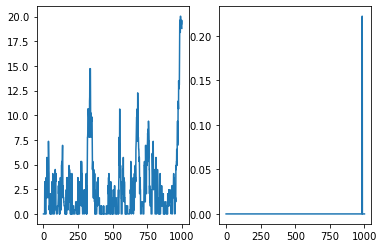

maximum steps, simulation is done ... 
elapsed_time: 51.163
Episode: 371 Exploration P: 0.0107 Total reward: -75.11703666209971 SOC: 0.5243 Cumulative_SOC_deviation: 37.1055 Fuel Consumption: 0.9060

maximum steps, simulation is done ... 
elapsed_time: 51.853
Episode: 372 Exploration P: 0.0107 Total reward: -90.74353849012206 SOC: 0.4942 Cumulative_SOC_deviation: 44.3770 Fuel Consumption: 1.9894

maximum steps, simulation is done ... 
elapsed_time: 51.818
Episode: 373 Exploration P: 0.0107 Total reward: -84.32670173933231 SOC: 0.4910 Cumulative_SOC_deviation: 41.1841 Fuel Consumption: 1.9585

maximum steps, simulation is done ... 
elapsed_time: 51.784
Episode: 374 Exploration P: 0.0106 Total reward: -104.91768205985507 SOC: 0.4933 Cumulative_SOC_deviation: 51.4383 Fuel Consumption: 2.0410

maximum steps, simulation is done ... 
elapsed_time: 51.912
Episode: 375 Exploration P: 0.0106 Total reward: -127.11767685449658 SOC: 0.3401 Cumulative_SOC_deviation: 59.7679 Fuel Consumption: 7.5819

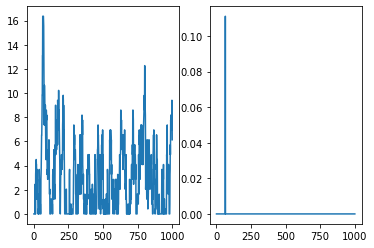

maximum steps, simulation is done ... 
elapsed_time: 51.280
Episode: 381 Exploration P: 0.0106 Total reward: -149.45060985837162 SOC: 0.4757 Cumulative_SOC_deviation: 74.0504 Fuel Consumption: 1.3497

maximum steps, simulation is done ... 
elapsed_time: 52.125
Episode: 382 Exploration P: 0.0106 Total reward: -205.12249637396357 SOC: 0.3688 Cumulative_SOC_deviation: 101.0609 Fuel Consumption: 3.0006

maximum steps, simulation is done ... 
elapsed_time: 52.018
Episode: 383 Exploration P: 0.0105 Total reward: -178.67149466905317 SOC: 0.4067 Cumulative_SOC_deviation: 88.6248 Fuel Consumption: 1.4220

maximum steps, simulation is done ... 
elapsed_time: 51.855
Episode: 384 Exploration P: 0.0105 Total reward: -114.34209528047386 SOC: 0.4978 Cumulative_SOC_deviation: 56.5220 Fuel Consumption: 1.2981

maximum steps, simulation is done ... 
elapsed_time: 52.094
Episode: 385 Exploration P: 0.0105 Total reward: -96.39369601878931 SOC: 0.4778 Cumulative_SOC_deviation: 46.7739 Fuel Consumption: 2.8

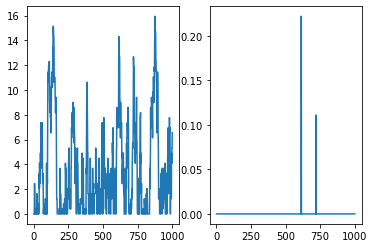

maximum steps, simulation is done ... 
elapsed_time: 51.397
Episode: 391 Exploration P: 0.0105 Total reward: -200.80214686525997 SOC: 0.4439 Cumulative_SOC_deviation: 99.3754 Fuel Consumption: 2.0514

maximum steps, simulation is done ... 
elapsed_time: 52.303
Episode: 392 Exploration P: 0.0105 Total reward: -115.80888577318389 SOC: 0.4667 Cumulative_SOC_deviation: 57.0181 Fuel Consumption: 1.7728

maximum steps, simulation is done ... 
elapsed_time: 52.128
Episode: 393 Exploration P: 0.0104 Total reward: -105.6840823997481 SOC: 0.4809 Cumulative_SOC_deviation: 51.8215 Fuel Consumption: 2.0410

maximum steps, simulation is done ... 
elapsed_time: 52.266
Episode: 394 Exploration P: 0.0104 Total reward: -150.38801127983152 SOC: 0.4923 Cumulative_SOC_deviation: 74.0600 Fuel Consumption: 2.2680

maximum steps, simulation is done ... 
elapsed_time: 51.948
Episode: 395 Exploration P: 0.0104 Total reward: -342.23501128276035 SOC: 0.3338 Cumulative_SOC_deviation: 168.3893 Fuel Consumption: 5.4

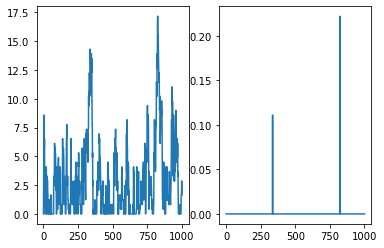

model is saved..

Trial 3

maximum steps, simulation is done ... 
elapsed_time: 9.236
Episode: 1 Exploration P: 1.0000 Total reward: -1144.067669926801 SOC: 1.0000 Cumulative_SOC_deviation: 347.8363 Fuel Consumption: 100.5586

maximum steps, simulation is done ... 
elapsed_time: 8.593
Episode: 2 Exploration P: 1.0000 Total reward: -1149.84769182584 SOC: 1.0000 Cumulative_SOC_deviation: 350.4681 Fuel Consumption: 98.4434

maximum steps, simulation is done ... 
elapsed_time: 8.077
Episode: 3 Exploration P: 1.0000 Total reward: -1169.2518685546925 SOC: 1.0000 Cumulative_SOC_deviation: 355.7840 Fuel Consumption: 101.9000

maximum steps, simulation is done ... 
elapsed_time: 8.303
Episode: 4 Exploration P: 1.0000 Total reward: -1179.7690102991992 SOC: 1.0000 Cumulative_SOC_deviation: 355.5064 Fuel Consumption: 113.2499


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X mode

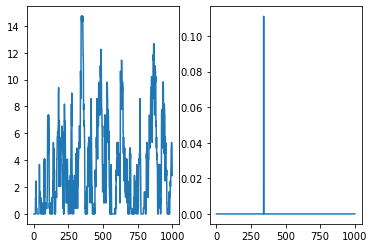

maximum steps, simulation is done ... 
elapsed_time: 49.932
Episode: 11 Exploration P: 0.8879 Total reward: -1142.0072925872798 SOC: 1.0000 Cumulative_SOC_deviation: 338.0146 Fuel Consumption: 127.9636

maximum steps, simulation is done ... 
elapsed_time: 50.825
Episode: 12 Exploration P: 0.8705 Total reward: -1143.322265596953 SOC: 0.9992 Cumulative_SOC_deviation: 350.9378 Fuel Consumption: 90.5088

maximum steps, simulation is done ... 
elapsed_time: 50.580
Episode: 13 Exploration P: 0.8534 Total reward: -1131.8182520853397 SOC: 1.0000 Cumulative_SOC_deviation: 347.0481 Fuel Consumption: 90.6738

maximum steps, simulation is done ... 
elapsed_time: 50.814
Episode: 14 Exploration P: 0.8367 Total reward: -1124.6833124517595 SOC: 1.0000 Cumulative_SOC_deviation: 344.9071 Fuel Consumption: 89.9619

maximum steps, simulation is done ... 
elapsed_time: 47.933
Episode: 15 Exploration P: 0.8203 Total reward: -1111.2537773030137 SOC: 1.0000 Cumulative_SOC_deviation: 340.9775 Fuel Consumption:

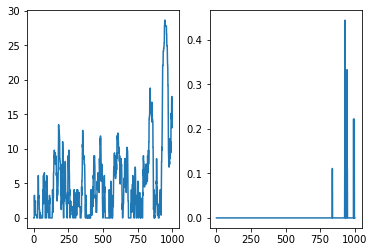

maximum steps, simulation is done ... 
elapsed_time: 49.196
Episode: 21 Exploration P: 0.7286 Total reward: -1086.2022185724718 SOC: 1.0000 Cumulative_SOC_deviation: 335.7087 Fuel Consumption: 79.0763

maximum steps, simulation is done ... 
elapsed_time: 50.836
Episode: 22 Exploration P: 0.7144 Total reward: -1069.5146559318484 SOC: 1.0000 Cumulative_SOC_deviation: 327.1917 Fuel Consumption: 87.9395

maximum steps, simulation is done ... 
elapsed_time: 50.768
Episode: 23 Exploration P: 0.7004 Total reward: -1078.3516733911179 SOC: 0.9985 Cumulative_SOC_deviation: 333.9413 Fuel Consumption: 76.5277

maximum steps, simulation is done ... 
elapsed_time: 51.008
Episode: 24 Exploration P: 0.6867 Total reward: -1078.0480590804834 SOC: 1.0000 Cumulative_SOC_deviation: 335.2331 Fuel Consumption: 72.3488

maximum steps, simulation is done ... 
elapsed_time: 50.948
Episode: 25 Exploration P: 0.6733 Total reward: -1070.5111627825797 SOC: 1.0000 Cumulative_SOC_deviation: 327.5067 Fuel Consumption:

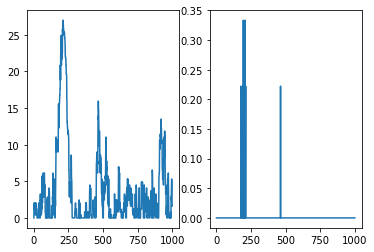

maximum steps, simulation is done ... 
elapsed_time: 49.772
Episode: 31 Exploration P: 0.5982 Total reward: -961.0965410815984 SOC: 0.9976 Cumulative_SOC_deviation: 297.3223 Fuel Consumption: 69.1296

maximum steps, simulation is done ... 
elapsed_time: 51.139
Episode: 32 Exploration P: 0.5866 Total reward: -867.3675286139221 SOC: 1.0000 Cumulative_SOC_deviation: 261.7044 Fuel Consumption: 82.2542

maximum steps, simulation is done ... 
elapsed_time: 51.174
Episode: 33 Exploration P: 0.5751 Total reward: -1013.8055883600023 SOC: 1.0000 Cumulative_SOC_deviation: 317.3580 Fuel Consumption: 61.7315

maximum steps, simulation is done ... 
elapsed_time: 51.212
Episode: 34 Exploration P: 0.5639 Total reward: -1001.5127863491831 SOC: 0.9999 Cumulative_SOC_deviation: 312.8030 Fuel Consumption: 63.1038

maximum steps, simulation is done ... 
elapsed_time: 51.284
Episode: 35 Exploration P: 0.5530 Total reward: -1001.0184869400131 SOC: 0.9996 Cumulative_SOC_deviation: 312.4112 Fuel Consumption: 6

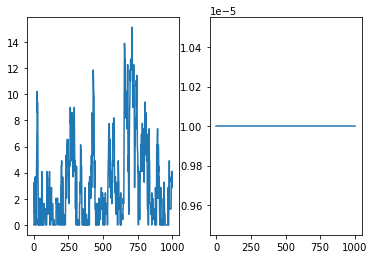

maximum steps, simulation is done ... 
elapsed_time: 49.712
Episode: 41 Exploration P: 0.4915 Total reward: -908.8764085677197 SOC: 1.0000 Cumulative_SOC_deviation: 279.9362 Fuel Consumption: 69.0677

maximum steps, simulation is done ... 
elapsed_time: 51.360
Episode: 42 Exploration P: 0.4820 Total reward: -912.3346725602761 SOC: 1.0000 Cumulative_SOC_deviation: 280.4218 Fuel Consumption: 71.0694

maximum steps, simulation is done ... 
elapsed_time: 51.410
Episode: 43 Exploration P: 0.4726 Total reward: -945.2291975776686 SOC: 1.0000 Cumulative_SOC_deviation: 297.2129 Fuel Consumption: 53.5905

maximum steps, simulation is done ... 
elapsed_time: 51.402
Episode: 44 Exploration P: 0.4634 Total reward: -971.6004864615752 SOC: 1.0000 Cumulative_SOC_deviation: 305.7901 Fuel Consumption: 54.2302

maximum steps, simulation is done ... 
elapsed_time: 51.673
Episode: 45 Exploration P: 0.4544 Total reward: -982.9420960607171 SOC: 1.0000 Cumulative_SOC_deviation: 309.0203 Fuel Consumption: 55.8

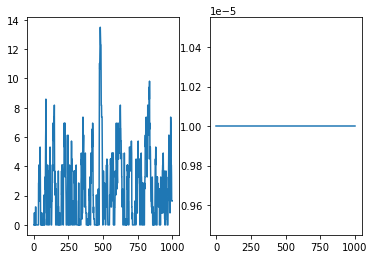

maximum steps, simulation is done ... 
elapsed_time: 49.962
Episode: 51 Exploration P: 0.4041 Total reward: -855.2053148854222 SOC: 0.9981 Cumulative_SOC_deviation: 268.8627 Fuel Consumption: 48.6171

maximum steps, simulation is done ... 
elapsed_time: 51.676
Episode: 52 Exploration P: 0.3963 Total reward: -889.477537409899 SOC: 1.0000 Cumulative_SOC_deviation: 280.6583 Fuel Consumption: 47.5028

maximum steps, simulation is done ... 
elapsed_time: 51.253
Episode: 53 Exploration P: 0.3887 Total reward: -820.6212107406628 SOC: 0.9988 Cumulative_SOC_deviation: 258.5282 Fuel Consumption: 45.0367

maximum steps, simulation is done ... 
elapsed_time: 51.440
Episode: 54 Exploration P: 0.3812 Total reward: -872.8121500584759 SOC: 0.9348 Cumulative_SOC_deviation: 273.7755 Fuel Consumption: 51.4856

maximum steps, simulation is done ... 
elapsed_time: 51.308
Episode: 55 Exploration P: 0.3738 Total reward: -766.4649437566492 SOC: 0.9997 Cumulative_SOC_deviation: 237.7246 Fuel Consumption: 53.29

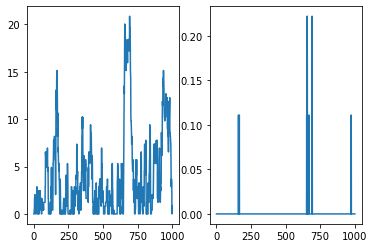

maximum steps, simulation is done ... 
elapsed_time: 50.353
Episode: 61 Exploration P: 0.3326 Total reward: -734.1185207822845 SOC: 0.9965 Cumulative_SOC_deviation: 231.1660 Fuel Consumption: 40.6206

maximum steps, simulation is done ... 
elapsed_time: 51.072
Episode: 62 Exploration P: 0.3262 Total reward: -650.8753228514098 SOC: 0.9449 Cumulative_SOC_deviation: 201.6779 Fuel Consumption: 45.8415

maximum steps, simulation is done ... 
elapsed_time: 51.650
Episode: 63 Exploration P: 0.3200 Total reward: -617.0252322825794 SOC: 0.9292 Cumulative_SOC_deviation: 191.3163 Fuel Consumption: 43.0763

maximum steps, simulation is done ... 
elapsed_time: 51.401
Episode: 64 Exploration P: 0.3138 Total reward: -728.268548523671 SOC: 0.9852 Cumulative_SOC_deviation: 229.6012 Fuel Consumption: 39.4649

maximum steps, simulation is done ... 
elapsed_time: 51.792
Episode: 65 Exploration P: 0.3078 Total reward: -708.5589434836949 SOC: 0.9880 Cumulative_SOC_deviation: 220.9368 Fuel Consumption: 45.74

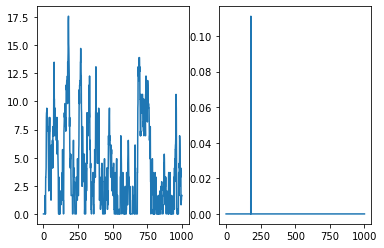

maximum steps, simulation is done ... 
elapsed_time: 50.533
Episode: 71 Exploration P: 0.2741 Total reward: -646.9990753479273 SOC: 0.9610 Cumulative_SOC_deviation: 203.1545 Fuel Consumption: 37.5354

maximum steps, simulation is done ... 
elapsed_time: 51.012
Episode: 72 Exploration P: 0.2689 Total reward: -690.3089441191621 SOC: 0.9747 Cumulative_SOC_deviation: 217.0993 Fuel Consumption: 39.0109

maximum steps, simulation is done ... 
elapsed_time: 51.795
Episode: 73 Exploration P: 0.2637 Total reward: -604.7013682244494 SOC: 0.9718 Cumulative_SOC_deviation: 189.1654 Fuel Consumption: 37.2053

maximum steps, simulation is done ... 
elapsed_time: 51.741
Episode: 74 Exploration P: 0.2587 Total reward: -624.4395175722645 SOC: 0.9540 Cumulative_SOC_deviation: 195.8170 Fuel Consumption: 36.9886

maximum steps, simulation is done ... 
elapsed_time: 51.645
Episode: 75 Exploration P: 0.2538 Total reward: -542.633643012769 SOC: 0.9326 Cumulative_SOC_deviation: 168.1700 Fuel Consumption: 38.12

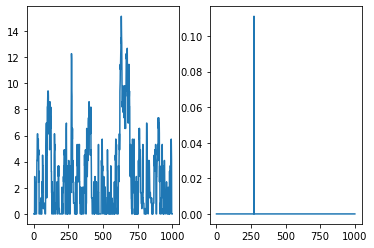

maximum steps, simulation is done ... 
elapsed_time: 50.083
Episode: 81 Exploration P: 0.2262 Total reward: -528.8900304681604 SOC: 0.9198 Cumulative_SOC_deviation: 165.0678 Fuel Consumption: 33.6868

maximum steps, simulation is done ... 
elapsed_time: 51.733
Episode: 82 Exploration P: 0.2219 Total reward: -442.42454647804254 SOC: 0.8976 Cumulative_SOC_deviation: 136.3904 Fuel Consumption: 33.2534

maximum steps, simulation is done ... 
elapsed_time: 51.623
Episode: 83 Exploration P: 0.2177 Total reward: -536.0307495454196 SOC: 0.8949 Cumulative_SOC_deviation: 167.0869 Fuel Consumption: 34.7702

maximum steps, simulation is done ... 
elapsed_time: 51.775
Episode: 84 Exploration P: 0.2136 Total reward: -413.9674577593436 SOC: 0.8000 Cumulative_SOC_deviation: 128.3974 Fuel Consumption: 28.7753

maximum steps, simulation is done ... 
elapsed_time: 51.630
Episode: 85 Exploration P: 0.2095 Total reward: -377.30420096875645 SOC: 0.8191 Cumulative_SOC_deviation: 115.7085 Fuel Consumption: 30

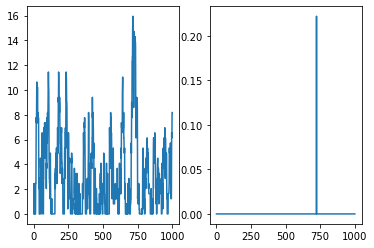

maximum steps, simulation is done ... 
elapsed_time: 50.098
Episode: 91 Exploration P: 0.1870 Total reward: -311.10711087229674 SOC: 0.8251 Cumulative_SOC_deviation: 94.5474 Fuel Consumption: 27.4649

maximum steps, simulation is done ... 
elapsed_time: 51.957
Episode: 92 Exploration P: 0.1834 Total reward: -285.20278269033315 SOC: 0.7776 Cumulative_SOC_deviation: 86.1946 Fuel Consumption: 26.6188

maximum steps, simulation is done ... 
elapsed_time: 51.678
Episode: 93 Exploration P: 0.1800 Total reward: -377.5214383834909 SOC: 0.8642 Cumulative_SOC_deviation: 116.2005 Fuel Consumption: 28.9198

maximum steps, simulation is done ... 
elapsed_time: 51.648
Episode: 94 Exploration P: 0.1766 Total reward: -430.1295233494243 SOC: 0.8794 Cumulative_SOC_deviation: 133.8294 Fuel Consumption: 28.6412

maximum steps, simulation is done ... 
elapsed_time: 52.056
Episode: 95 Exploration P: 0.1733 Total reward: -169.8461416348131 SOC: 0.7236 Cumulative_SOC_deviation: 49.6444 Fuel Consumption: 20.91

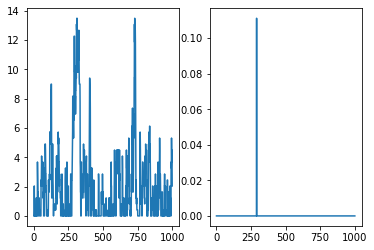

maximum steps, simulation is done ... 
elapsed_time: 50.772
Episode: 101 Exploration P: 0.1556 Total reward: -223.5989465900608 SOC: 0.7420 Cumulative_SOC_deviation: 67.0358 Fuel Consumption: 22.4916

maximum steps, simulation is done ... 
elapsed_time: 51.267
Episode: 102 Exploration P: 0.1527 Total reward: -262.9353146462251 SOC: 0.7842 Cumulative_SOC_deviation: 80.9424 Fuel Consumption: 20.1081

maximum steps, simulation is done ... 
elapsed_time: 51.700
Episode: 103 Exploration P: 0.1498 Total reward: -205.48212197113165 SOC: 0.7233 Cumulative_SOC_deviation: 61.4818 Fuel Consumption: 21.0367

maximum steps, simulation is done ... 
elapsed_time: 52.022
Episode: 104 Exploration P: 0.1471 Total reward: -258.6413308264303 SOC: 0.7523 Cumulative_SOC_deviation: 78.0837 Fuel Consumption: 24.3901

maximum steps, simulation is done ... 
elapsed_time: 51.677
Episode: 105 Exploration P: 0.1444 Total reward: -176.13581996113103 SOC: 0.6217 Cumulative_SOC_deviation: 51.1975 Fuel Consumption: 22

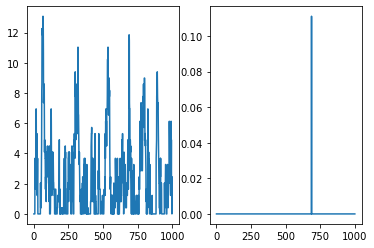

maximum steps, simulation is done ... 
elapsed_time: 51.023
Episode: 111 Exploration P: 0.1292 Total reward: -57.728188507322386 SOC: 0.5683 Cumulative_SOC_deviation: 11.6733 Fuel Consumption: 22.7083

maximum steps, simulation is done ... 
elapsed_time: 51.337
Episode: 112 Exploration P: 0.1268 Total reward: -286.95386844075114 SOC: 0.7612 Cumulative_SOC_deviation: 89.0346 Fuel Consumption: 19.8501

maximum steps, simulation is done ... 
elapsed_time: 51.873
Episode: 113 Exploration P: 0.1245 Total reward: -194.63338311921189 SOC: 0.6818 Cumulative_SOC_deviation: 58.3195 Fuel Consumption: 19.6747

maximum steps, simulation is done ... 
elapsed_time: 51.782
Episode: 114 Exploration P: 0.1222 Total reward: -127.82603496864093 SOC: 0.5919 Cumulative_SOC_deviation: 36.9000 Fuel Consumption: 17.1262

maximum steps, simulation is done ... 
elapsed_time: 51.758
Episode: 115 Exploration P: 0.1200 Total reward: -178.02613500503332 SOC: 0.6811 Cumulative_SOC_deviation: 51.6075 Fuel Consumption:

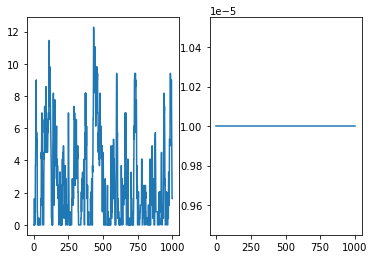

maximum steps, simulation is done ... 
elapsed_time: 51.019
Episode: 121 Exploration P: 0.1075 Total reward: -295.75956554972635 SOC: 0.2168 Cumulative_SOC_deviation: 90.8520 Fuel Consumption: 23.2035

maximum steps, simulation is done ... 
elapsed_time: 51.389
Episode: 122 Exploration P: 0.1056 Total reward: -124.49230790003135 SOC: 0.6488 Cumulative_SOC_deviation: 36.6314 Fuel Consumption: 14.5982

maximum steps, simulation is done ... 
elapsed_time: 51.973
Episode: 123 Exploration P: 0.1037 Total reward: -79.58629675182567 SOC: 0.6453 Cumulative_SOC_deviation: 22.3712 Fuel Consumption: 12.4727

maximum steps, simulation is done ... 
elapsed_time: 51.976
Episode: 124 Exploration P: 0.1018 Total reward: -94.9981151473561 SOC: 0.5737 Cumulative_SOC_deviation: 25.6994 Fuel Consumption: 17.9000

maximum steps, simulation is done ... 
elapsed_time: 51.821
Episode: 125 Exploration P: 0.1000 Total reward: -150.61653066765786 SOC: 0.6607 Cumulative_SOC_deviation: 45.5080 Fuel Consumption: 14

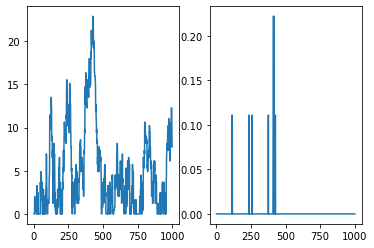

maximum steps, simulation is done ... 
elapsed_time: 51.287
Episode: 131 Exploration P: 0.0898 Total reward: -171.66252971161583 SOC: 0.5311 Cumulative_SOC_deviation: 53.5207 Fuel Consumption: 11.1004

maximum steps, simulation is done ... 
elapsed_time: 50.878
Episode: 132 Exploration P: 0.0883 Total reward: -136.3217332099803 SOC: 0.4776 Cumulative_SOC_deviation: 41.1076 Fuel Consumption: 12.9989

maximum steps, simulation is done ... 
elapsed_time: 52.175
Episode: 133 Exploration P: 0.0867 Total reward: -96.17123658905356 SOC: 0.6708 Cumulative_SOC_deviation: 27.4352 Fuel Consumption: 13.8656

maximum steps, simulation is done ... 
elapsed_time: 51.902
Episode: 134 Exploration P: 0.0852 Total reward: -124.91822507084738 SOC: 0.5068 Cumulative_SOC_deviation: 35.9582 Fuel Consumption: 17.0436

maximum steps, simulation is done ... 
elapsed_time: 51.939
Episode: 135 Exploration P: 0.0837 Total reward: -96.97915799561979 SOC: 0.5982 Cumulative_SOC_deviation: 28.0622 Fuel Consumption: 12

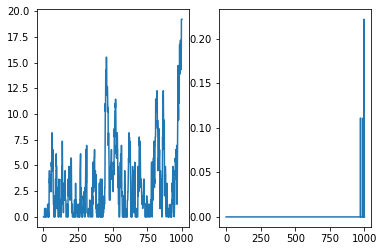

maximum steps, simulation is done ... 
elapsed_time: 51.411
Episode: 141 Exploration P: 0.0754 Total reward: -47.3303785691159 SOC: 0.6019 Cumulative_SOC_deviation: 11.4989 Fuel Consumption: 12.8338

maximum steps, simulation is done ... 
elapsed_time: 50.963
Episode: 142 Exploration P: 0.0741 Total reward: -96.20439401463322 SOC: 0.6208 Cumulative_SOC_deviation: 28.1857 Fuel Consumption: 11.6472

maximum steps, simulation is done ... 
elapsed_time: 52.070
Episode: 143 Exploration P: 0.0728 Total reward: -731.183161636613 SOC: 0.2618 Cumulative_SOC_deviation: 237.6441 Fuel Consumption: 18.2508

maximum steps, simulation is done ... 
elapsed_time: 51.755
Episode: 144 Exploration P: 0.0715 Total reward: -28.62039090282874 SOC: 0.6120 Cumulative_SOC_deviation: 6.2115 Fuel Consumption: 9.9860

maximum steps, simulation is done ... 
elapsed_time: 51.995
Episode: 145 Exploration P: 0.0703 Total reward: -93.05737906633613 SOC: 0.5444 Cumulative_SOC_deviation: 27.2468 Fuel Consumption: 11.3170

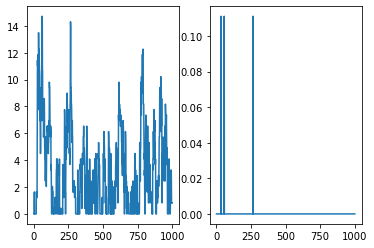

maximum steps, simulation is done ... 
elapsed_time: 51.580
Episode: 151 Exploration P: 0.0635 Total reward: -58.30873790850116 SOC: 0.5695 Cumulative_SOC_deviation: 16.5650 Fuel Consumption: 8.6137

maximum steps, simulation is done ... 
elapsed_time: 50.584
Episode: 152 Exploration P: 0.0624 Total reward: -85.6402359247624 SOC: 0.6089 Cumulative_SOC_deviation: 25.4141 Fuel Consumption: 9.3979

maximum steps, simulation is done ... 
elapsed_time: 51.823
Episode: 153 Exploration P: 0.0614 Total reward: -41.57450580885317 SOC: 0.6080 Cumulative_SOC_deviation: 11.0282 Fuel Consumption: 8.4899

maximum steps, simulation is done ... 
elapsed_time: 51.757
Episode: 154 Exploration P: 0.0604 Total reward: -104.95267750442643 SOC: 0.5415 Cumulative_SOC_deviation: 32.0373 Fuel Consumption: 8.8407

maximum steps, simulation is done ... 
elapsed_time: 51.970
Episode: 155 Exploration P: 0.0594 Total reward: -19.89899988206089 SOC: 0.5990 Cumulative_SOC_deviation: 4.1470 Fuel Consumption: 7.4581

m

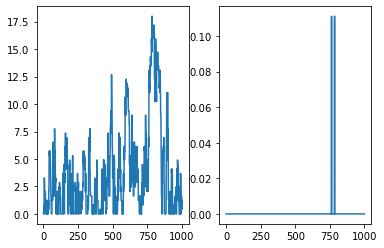

maximum steps, simulation is done ... 
elapsed_time: 51.906
Episode: 161 Exploration P: 0.0538 Total reward: -113.55920216908788 SOC: 0.5260 Cumulative_SOC_deviation: 34.7858 Fuel Consumption: 9.2018

maximum steps, simulation is done ... 
elapsed_time: 50.219
Episode: 162 Exploration P: 0.0529 Total reward: -70.39431612003334 SOC: 0.6187 Cumulative_SOC_deviation: 19.7657 Fuel Consumption: 11.0973

maximum steps, simulation is done ... 
elapsed_time: 51.808
Episode: 163 Exploration P: 0.0521 Total reward: -133.3865931027194 SOC: 0.6798 Cumulative_SOC_deviation: 37.0317 Fuel Consumption: 22.2914

maximum steps, simulation is done ... 
elapsed_time: 51.563
Episode: 164 Exploration P: 0.0512 Total reward: -48.195492236373816 SOC: 0.6052 Cumulative_SOC_deviation: 11.5665 Fuel Consumption: 13.4960

maximum steps, simulation is done ... 
elapsed_time: 51.873
Episode: 165 Exploration P: 0.0504 Total reward: -62.538332335205695 SOC: 0.5735 Cumulative_SOC_deviation: 17.3780 Fuel Consumption: 10

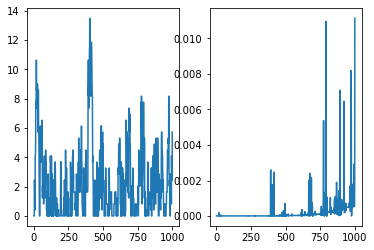

maximum steps, simulation is done ... 
elapsed_time: 51.918
Episode: 171 Exploration P: 0.0458 Total reward: -70.96231761456154 SOC: 0.5801 Cumulative_SOC_deviation: 19.6009 Fuel Consumption: 12.1597

maximum steps, simulation is done ... 
elapsed_time: 50.239
Episode: 172 Exploration P: 0.0451 Total reward: -55.07050221093393 SOC: 0.5284 Cumulative_SOC_deviation: 16.5621 Fuel Consumption: 5.3841

maximum steps, simulation is done ... 
elapsed_time: 51.806
Episode: 173 Exploration P: 0.0444 Total reward: -379.7009219053075 SOC: 0.4127 Cumulative_SOC_deviation: 123.5687 Fuel Consumption: 8.9948

maximum steps, simulation is done ... 
elapsed_time: 52.191
Episode: 174 Exploration P: 0.0438 Total reward: -76.80945584724076 SOC: 0.5527 Cumulative_SOC_deviation: 23.2478 Fuel Consumption: 7.0660

maximum steps, simulation is done ... 
elapsed_time: 51.969
Episode: 175 Exploration P: 0.0431 Total reward: -234.45539910322861 SOC: 0.4810 Cumulative_SOC_deviation: 74.5130 Fuel Consumption: 10.91

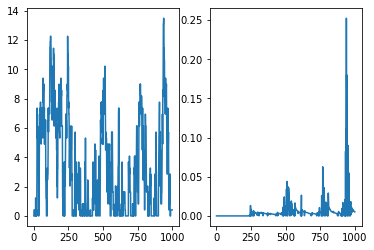

maximum steps, simulation is done ... 
elapsed_time: 51.851
Episode: 181 Exploration P: 0.0393 Total reward: -101.77156612643783 SOC: 0.6068 Cumulative_SOC_deviation: 29.3717 Fuel Consumption: 13.6564

maximum steps, simulation is done ... 
elapsed_time: 50.208
Episode: 182 Exploration P: 0.0388 Total reward: -60.726626292667845 SOC: 0.5704 Cumulative_SOC_deviation: 12.0189 Fuel Consumption: 24.6698

maximum steps, simulation is done ... 
elapsed_time: 51.821
Episode: 183 Exploration P: 0.0382 Total reward: -84.60775364815404 SOC: 0.5981 Cumulative_SOC_deviation: 24.8886 Fuel Consumption: 9.9420

maximum steps, simulation is done ... 
elapsed_time: 51.859
Episode: 184 Exploration P: 0.0376 Total reward: -48.049593988570614 SOC: 0.5857 Cumulative_SOC_deviation: 10.3409 Fuel Consumption: 17.0268

maximum steps, simulation is done ... 
elapsed_time: 52.014
Episode: 185 Exploration P: 0.0371 Total reward: -83.53564290725446 SOC: 0.6224 Cumulative_SOC_deviation: 22.5221 Fuel Consumption: 15

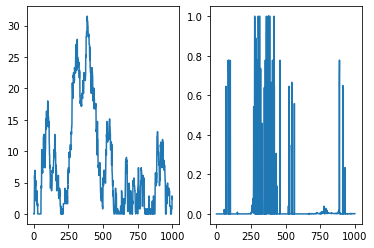

maximum steps, simulation is done ... 
elapsed_time: 51.836
Episode: 191 Exploration P: 0.0340 Total reward: -31.06844293510831 SOC: 0.6133 Cumulative_SOC_deviation: 6.7654 Fuel Consumption: 10.7722

maximum steps, simulation is done ... 
elapsed_time: 50.289
Episode: 192 Exploration P: 0.0335 Total reward: -38.44499247495983 SOC: 0.6099 Cumulative_SOC_deviation: 9.2016 Fuel Consumption: 10.8403

maximum steps, simulation is done ... 
elapsed_time: 51.908
Episode: 193 Exploration P: 0.0331 Total reward: -54.89386965676126 SOC: 0.6120 Cumulative_SOC_deviation: 15.0556 Fuel Consumption: 9.7270

maximum steps, simulation is done ... 
elapsed_time: 52.030
Episode: 194 Exploration P: 0.0326 Total reward: -37.735100407979296 SOC: 0.5896 Cumulative_SOC_deviation: 8.1954 Fuel Consumption: 13.1488

maximum steps, simulation is done ... 
elapsed_time: 51.917
Episode: 195 Exploration P: 0.0322 Total reward: -74.83434412741346 SOC: 0.5709 Cumulative_SOC_deviation: 21.7446 Fuel Consumption: 9.6006


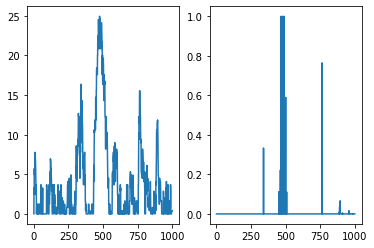

maximum steps, simulation is done ... 
elapsed_time: 52.028
Episode: 201 Exploration P: 0.0297 Total reward: -121.64620725116156 SOC: 0.6240 Cumulative_SOC_deviation: 33.3673 Fuel Consumption: 21.5444

maximum steps, simulation is done ... 
elapsed_time: 50.394
Episode: 202 Exploration P: 0.0293 Total reward: -42.94085685262786 SOC: 0.5897 Cumulative_SOC_deviation: 11.5908 Fuel Consumption: 8.1685

maximum steps, simulation is done ... 
elapsed_time: 51.998
Episode: 203 Exploration P: 0.0289 Total reward: -86.0597017296553 SOC: 0.5329 Cumulative_SOC_deviation: 24.3468 Fuel Consumption: 13.0194

maximum steps, simulation is done ... 
elapsed_time: 51.918
Episode: 204 Exploration P: 0.0285 Total reward: -59.19961843894304 SOC: 0.5689 Cumulative_SOC_deviation: 17.7634 Fuel Consumption: 5.9095

maximum steps, simulation is done ... 
elapsed_time: 51.854
Episode: 205 Exploration P: 0.0281 Total reward: -85.00427207665103 SOC: 0.5550 Cumulative_SOC_deviation: 26.5735 Fuel Consumption: 5.2839

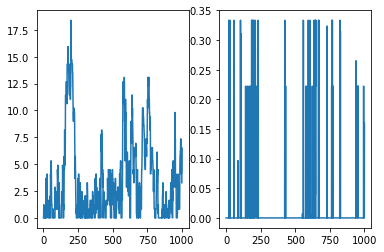

maximum steps, simulation is done ... 
elapsed_time: 51.997
Episode: 211 Exploration P: 0.0261 Total reward: -163.52047557673592 SOC: 0.6361 Cumulative_SOC_deviation: 45.1233 Fuel Consumption: 28.1506

maximum steps, simulation is done ... 
elapsed_time: 50.866
Episode: 212 Exploration P: 0.0258 Total reward: -73.6119272298271 SOC: 0.5620 Cumulative_SOC_deviation: 22.0812 Fuel Consumption: 7.3685

maximum steps, simulation is done ... 
elapsed_time: 51.555
Episode: 213 Exploration P: 0.0255 Total reward: -114.47752233293937 SOC: 0.6151 Cumulative_SOC_deviation: 34.2326 Fuel Consumption: 11.7796

maximum steps, simulation is done ... 
elapsed_time: 51.814
Episode: 214 Exploration P: 0.0252 Total reward: -85.14618202767316 SOC: 0.6183 Cumulative_SOC_deviation: 17.3254 Fuel Consumption: 33.1699

maximum steps, simulation is done ... 
elapsed_time: 51.930
Episode: 215 Exploration P: 0.0249 Total reward: -143.87487568967126 SOC: 0.4732 Cumulative_SOC_deviation: 44.6699 Fuel Consumption: 9.8

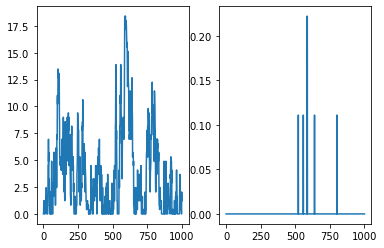

maximum steps, simulation is done ... 
elapsed_time: 51.857
Episode: 221 Exploration P: 0.0232 Total reward: -21.19390612943246 SOC: 0.5856 Cumulative_SOC_deviation: 5.4660 Fuel Consumption: 4.7960

maximum steps, simulation is done ... 
elapsed_time: 51.296
Episode: 222 Exploration P: 0.0229 Total reward: -196.53889165084823 SOC: 0.4680 Cumulative_SOC_deviation: 64.6022 Fuel Consumption: 2.7324

maximum steps, simulation is done ... 
elapsed_time: 51.055
Episode: 223 Exploration P: 0.0227 Total reward: -116.38548626086883 SOC: 0.5244 Cumulative_SOC_deviation: 37.6574 Fuel Consumption: 3.4134

maximum steps, simulation is done ... 
elapsed_time: 52.137
Episode: 224 Exploration P: 0.0224 Total reward: -241.45548871181978 SOC: 0.4176 Cumulative_SOC_deviation: 78.4394 Fuel Consumption: 6.1373

maximum steps, simulation is done ... 
elapsed_time: 51.944
Episode: 225 Exploration P: 0.0222 Total reward: -61.23359211077442 SOC: 0.5562 Cumulative_SOC_deviation: 19.1565 Fuel Consumption: 3.7642

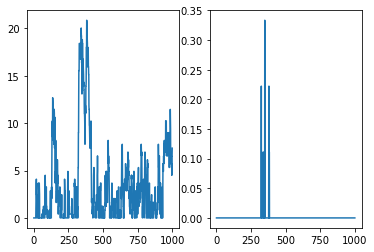

maximum steps, simulation is done ... 
elapsed_time: 52.040
Episode: 231 Exploration P: 0.0208 Total reward: -178.8474795125823 SOC: 0.5049 Cumulative_SOC_deviation: 58.7119 Fuel Consumption: 2.7117

maximum steps, simulation is done ... 
elapsed_time: 51.123
Episode: 232 Exploration P: 0.0206 Total reward: -158.34779531372052 SOC: 0.3712 Cumulative_SOC_deviation: 50.2450 Fuel Consumption: 7.6128

maximum steps, simulation is done ... 
elapsed_time: 51.588
Episode: 233 Exploration P: 0.0204 Total reward: -402.0114819238353 SOC: 0.2358 Cumulative_SOC_deviation: 130.7990 Fuel Consumption: 9.6146

maximum steps, simulation is done ... 
elapsed_time: 51.931
Episode: 234 Exploration P: 0.0202 Total reward: -111.45035412541041 SOC: 0.5100 Cumulative_SOC_deviation: 36.5110 Fuel Consumption: 1.9172

maximum steps, simulation is done ... 
elapsed_time: 51.815
Episode: 235 Exploration P: 0.0200 Total reward: -149.2077627938777 SOC: 0.5110 Cumulative_SOC_deviation: 48.8939 Fuel Consumption: 2.526

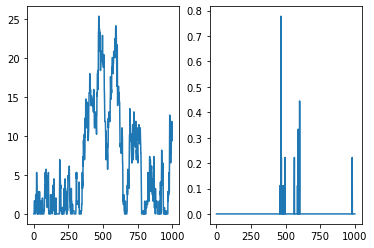

maximum steps, simulation is done ... 
elapsed_time: 51.958
Episode: 241 Exploration P: 0.0188 Total reward: -115.5597849090425 SOC: 0.5098 Cumulative_SOC_deviation: 37.6091 Fuel Consumption: 2.7324

maximum steps, simulation is done ... 
elapsed_time: 51.258
Episode: 242 Exploration P: 0.0187 Total reward: -176.48342287846003 SOC: 0.3861 Cumulative_SOC_deviation: 57.8001 Fuel Consumption: 3.0832

maximum steps, simulation is done ... 
elapsed_time: 50.955
Episode: 243 Exploration P: 0.0185 Total reward: -303.6512160094685 SOC: 0.3912 Cumulative_SOC_deviation: 99.4258 Fuel Consumption: 5.3738

maximum steps, simulation is done ... 
elapsed_time: 52.157
Episode: 244 Exploration P: 0.0183 Total reward: -292.25983597468843 SOC: 0.3832 Cumulative_SOC_deviation: 94.8858 Fuel Consumption: 7.6025

maximum steps, simulation is done ... 
elapsed_time: 52.010
Episode: 245 Exploration P: 0.0181 Total reward: -240.183074962635 SOC: 0.4774 Cumulative_SOC_deviation: 79.0058 Fuel Consumption: 3.1657


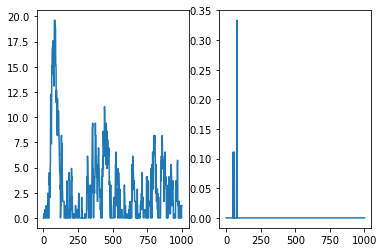

maximum steps, simulation is done ... 
elapsed_time: 51.912
Episode: 251 Exploration P: 0.0172 Total reward: -394.4956562559267 SOC: 0.4009 Cumulative_SOC_deviation: 129.5628 Fuel Consumption: 5.8072

maximum steps, simulation is done ... 
elapsed_time: 51.154
Episode: 252 Exploration P: 0.0171 Total reward: -225.2201395283514 SOC: 0.4660 Cumulative_SOC_deviation: 74.6475 Fuel Consumption: 1.2775

maximum steps, simulation is done ... 
elapsed_time: 50.910
Episode: 253 Exploration P: 0.0169 Total reward: -95.18320561929599 SOC: 0.4992 Cumulative_SOC_deviation: 30.6003 Fuel Consumption: 3.3824

maximum steps, simulation is done ... 
elapsed_time: 51.978
Episode: 254 Exploration P: 0.0168 Total reward: -189.52118952307168 SOC: 0.4740 Cumulative_SOC_deviation: 62.8614 Fuel Consumption: 0.9370

maximum steps, simulation is done ... 
elapsed_time: 51.974
Episode: 255 Exploration P: 0.0167 Total reward: -81.98603482365168 SOC: 0.5540 Cumulative_SOC_deviation: 26.4936 Fuel Consumption: 2.5054

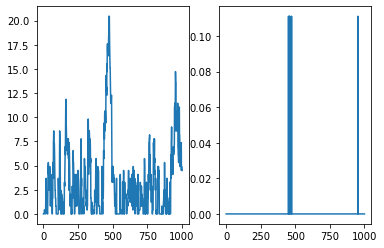

maximum steps, simulation is done ... 
elapsed_time: 53.954
Episode: 261 Exploration P: 0.0159 Total reward: -525.4206983479116 SOC: 0.3238 Cumulative_SOC_deviation: 173.0050 Fuel Consumption: 6.4056

maximum steps, simulation is done ... 
elapsed_time: 53.478
Episode: 262 Exploration P: 0.0158 Total reward: -117.73510958032672 SOC: 0.5107 Cumulative_SOC_deviation: 38.6610 Fuel Consumption: 1.7521

maximum steps, simulation is done ... 
elapsed_time: 51.259
Episode: 263 Exploration P: 0.0157 Total reward: -633.2678581143555 SOC: 0.2412 Cumulative_SOC_deviation: 206.9489 Fuel Consumption: 12.4211

maximum steps, simulation is done ... 
elapsed_time: 51.633
Episode: 264 Exploration P: 0.0156 Total reward: -236.74038180002603 SOC: 0.4682 Cumulative_SOC_deviation: 78.1059 Fuel Consumption: 2.4228

maximum steps, simulation is done ... 
elapsed_time: 51.914
Episode: 265 Exploration P: 0.0155 Total reward: -257.7471941207088 SOC: 0.4571 Cumulative_SOC_deviation: 85.2388 Fuel Consumption: 2.0

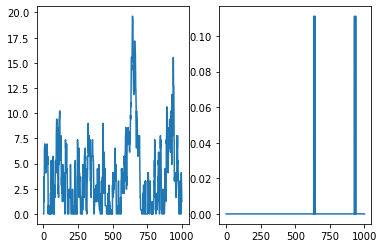

maximum steps, simulation is done ... 
elapsed_time: 51.774
Episode: 271 Exploration P: 0.0149 Total reward: -133.75661895861433 SOC: 0.5181 Cumulative_SOC_deviation: 43.6713 Fuel Consumption: 2.7427

maximum steps, simulation is done ... 
elapsed_time: 51.899
Episode: 272 Exploration P: 0.0148 Total reward: -128.03180040240807 SOC: 0.5242 Cumulative_SOC_deviation: 41.6495 Fuel Consumption: 3.0832

maximum steps, simulation is done ... 
elapsed_time: 51.062
Episode: 273 Exploration P: 0.0147 Total reward: -297.7695572686183 SOC: 0.4148 Cumulative_SOC_deviation: 98.5039 Fuel Consumption: 2.2577

maximum steps, simulation is done ... 
elapsed_time: 50.873
Episode: 274 Exploration P: 0.0146 Total reward: -170.14452351658875 SOC: 0.4739 Cumulative_SOC_deviation: 55.6768 Fuel Consumption: 3.1141

maximum steps, simulation is done ... 
elapsed_time: 51.902
Episode: 275 Exploration P: 0.0145 Total reward: -122.16628520889596 SOC: 0.4948 Cumulative_SOC_deviation: 40.2756 Fuel Consumption: 1.33

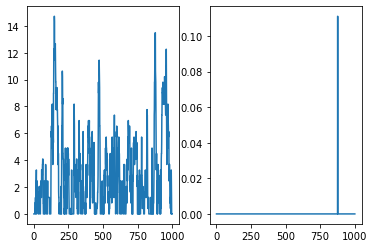

maximum steps, simulation is done ... 
elapsed_time: 51.972
Episode: 281 Exploration P: 0.0140 Total reward: -183.20135360062116 SOC: 0.4701 Cumulative_SOC_deviation: 59.7367 Fuel Consumption: 3.9912

maximum steps, simulation is done ... 
elapsed_time: 51.658
Episode: 282 Exploration P: 0.0139 Total reward: -346.98170801997753 SOC: 0.4377 Cumulative_SOC_deviation: 114.6707 Fuel Consumption: 2.9697

maximum steps, simulation is done ... 
elapsed_time: 50.485
Episode: 283 Exploration P: 0.0139 Total reward: -328.95129367383356 SOC: 0.4432 Cumulative_SOC_deviation: 109.0354 Fuel Consumption: 1.8450

maximum steps, simulation is done ... 
elapsed_time: 51.909
Episode: 284 Exploration P: 0.0138 Total reward: -72.12538316401587 SOC: 0.5482 Cumulative_SOC_deviation: 23.4371 Fuel Consumption: 1.8140

maximum steps, simulation is done ... 
elapsed_time: 52.051
Episode: 285 Exploration P: 0.0137 Total reward: -92.54873968119634 SOC: 0.5479 Cumulative_SOC_deviation: 30.3137 Fuel Consumption: 1.6

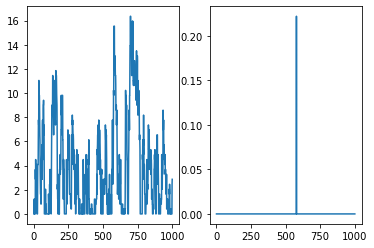

maximum steps, simulation is done ... 
elapsed_time: 51.693
Episode: 291 Exploration P: 0.0133 Total reward: -215.98761911889898 SOC: 0.4719 Cumulative_SOC_deviation: 71.4497 Fuel Consumption: 1.6386

maximum steps, simulation is done ... 
elapsed_time: 51.795
Episode: 292 Exploration P: 0.0132 Total reward: -166.89752047818044 SOC: 0.4670 Cumulative_SOC_deviation: 54.6185 Fuel Consumption: 3.0419

maximum steps, simulation is done ... 
elapsed_time: 50.698
Episode: 293 Exploration P: 0.0132 Total reward: -480.99539665182044 SOC: 0.2177 Cumulative_SOC_deviation: 157.7082 Fuel Consumption: 7.8708

maximum steps, simulation is done ... 
elapsed_time: 51.661
Episode: 294 Exploration P: 0.0131 Total reward: -201.1707030909361 SOC: 0.4303 Cumulative_SOC_deviation: 66.3594 Fuel Consumption: 2.0926

maximum steps, simulation is done ... 
elapsed_time: 51.906
Episode: 295 Exploration P: 0.0130 Total reward: -256.8676742204346 SOC: 0.3910 Cumulative_SOC_deviation: 84.6843 Fuel Consumption: 2.81

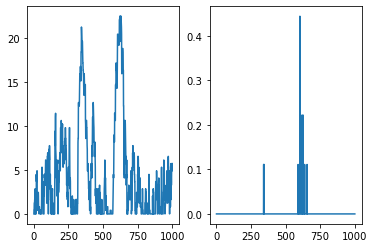

maximum steps, simulation is done ... 
elapsed_time: 51.877
Episode: 301 Exploration P: 0.0127 Total reward: -117.49137043442121 SOC: 0.4992 Cumulative_SOC_deviation: 38.5316 Fuel Consumption: 1.8966

maximum steps, simulation is done ... 
elapsed_time: 51.587
Episode: 302 Exploration P: 0.0126 Total reward: -183.50571178853832 SOC: 0.4960 Cumulative_SOC_deviation: 60.6808 Fuel Consumption: 1.4632

battery power is 112029.54100704161(+) but condition is not avail
elapsed_time: 32.681
Episode: 303 Exploration P: 0.0126 Total reward: -1345.5529532211876 SOC: 0.1872 Cumulative_SOC_deviation: 112.2935 Fuel Consumption: 9.9108

maximum steps, simulation is done ... 
elapsed_time: 51.242
Episode: 304 Exploration P: 0.0126 Total reward: -134.72287431422401 SOC: 0.4936 Cumulative_SOC_deviation: 44.3511 Fuel Consumption: 1.6696

maximum steps, simulation is done ... 
elapsed_time: 51.772
Episode: 305 Exploration P: 0.0125 Total reward: -131.2252107302853 SOC: 0.5031 Cumulative_SOC_deviation: 43

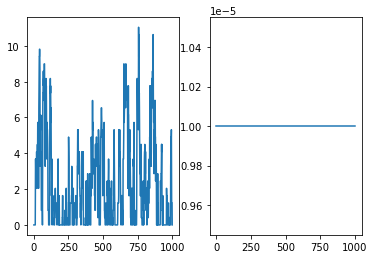

battery power is 111886.35345025528(+) but condition is not avail
elapsed_time: 3.948
Episode: 311 Exploration P: 0.0123 Total reward: -1010.6000417419344 SOC: 0.4864 Cumulative_SOC_deviation: 2.9864 Fuel Consumption: 1.9817

maximum steps, simulation is done ... 
elapsed_time: 51.691
Episode: 312 Exploration P: 0.0122 Total reward: -193.96098553386415 SOC: 0.4729 Cumulative_SOC_deviation: 64.1246 Fuel Consumption: 1.5870

maximum steps, simulation is done ... 
elapsed_time: 51.847
Episode: 313 Exploration P: 0.0122 Total reward: -57.05984299718118 SOC: 0.5610 Cumulative_SOC_deviation: 17.8718 Fuel Consumption: 3.4443

maximum steps, simulation is done ... 
elapsed_time: 51.298
Episode: 314 Exploration P: 0.0121 Total reward: -171.59278300163257 SOC: 0.4779 Cumulative_SOC_deviation: 56.6892 Fuel Consumption: 1.5251

maximum steps, simulation is done ... 
elapsed_time: 50.964
Episode: 315 Exploration P: 0.0121 Total reward: -149.57275569218015 SOC: 0.5093 Cumulative_SOC_deviation: 49.02

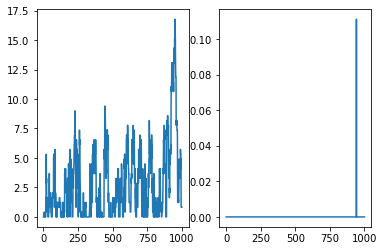

maximum steps, simulation is done ... 
elapsed_time: 51.967
Episode: 321 Exploration P: 0.0118 Total reward: -135.64510773997446 SOC: 0.5125 Cumulative_SOC_deviation: 44.5347 Fuel Consumption: 2.0410

maximum steps, simulation is done ... 
elapsed_time: 51.569
Episode: 322 Exploration P: 0.0118 Total reward: -87.7140528049321 SOC: 0.5155 Cumulative_SOC_deviation: 28.5680 Fuel Consumption: 2.0101

maximum steps, simulation is done ... 
elapsed_time: 51.945
Episode: 323 Exploration P: 0.0118 Total reward: -380.3420615173482 SOC: 0.4275 Cumulative_SOC_deviation: 125.9421 Fuel Consumption: 2.5157

maximum steps, simulation is done ... 
elapsed_time: 51.296
Episode: 324 Exploration P: 0.0117 Total reward: -139.83199718281418 SOC: 0.4687 Cumulative_SOC_deviation: 46.0369 Fuel Consumption: 1.7212

maximum steps, simulation is done ... 
elapsed_time: 50.970
Episode: 325 Exploration P: 0.0117 Total reward: -214.3531481266971 SOC: 0.4449 Cumulative_SOC_deviation: 70.2101 Fuel Consumption: 3.7229

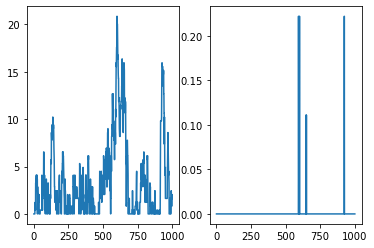

maximum steps, simulation is done ... 
elapsed_time: 51.864
Episode: 331 Exploration P: 0.0115 Total reward: -190.13749593904973 SOC: 0.4564 Cumulative_SOC_deviation: 62.2758 Fuel Consumption: 3.3102

maximum steps, simulation is done ... 
elapsed_time: 51.573
Episode: 332 Exploration P: 0.0115 Total reward: -169.11334839816445 SOC: 0.5142 Cumulative_SOC_deviation: 55.7183 Fuel Consumption: 1.9585

maximum steps, simulation is done ... 
elapsed_time: 51.854
Episode: 333 Exploration P: 0.0115 Total reward: -242.57583458522583 SOC: 0.4655 Cumulative_SOC_deviation: 80.2161 Fuel Consumption: 1.9275

maximum steps, simulation is done ... 
elapsed_time: 51.192
Episode: 334 Exploration P: 0.0114 Total reward: -318.46936913184277 SOC: 0.3960 Cumulative_SOC_deviation: 104.3274 Fuel Consumption: 5.4873

maximum steps, simulation is done ... 
elapsed_time: 51.240
Episode: 335 Exploration P: 0.0114 Total reward: -85.84209693792181 SOC: 0.5093 Cumulative_SOC_deviation: 27.6998 Fuel Consumption: 2.7

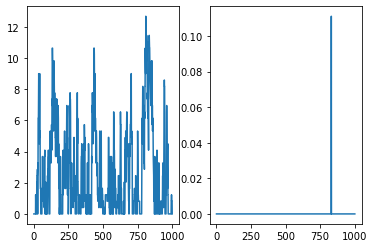

maximum steps, simulation is done ... 
elapsed_time: 52.096
Episode: 341 Exploration P: 0.0112 Total reward: -368.0921203843544 SOC: 0.3408 Cumulative_SOC_deviation: 121.4461 Fuel Consumption: 3.7539

maximum steps, simulation is done ... 
elapsed_time: 52.015
Episode: 342 Exploration P: 0.0112 Total reward: -201.0275265463584 SOC: 0.4510 Cumulative_SOC_deviation: 66.3220 Fuel Consumption: 2.0617

maximum steps, simulation is done ... 
elapsed_time: 51.855
Episode: 343 Exploration P: 0.0112 Total reward: -421.3757560698778 SOC: 0.3744 Cumulative_SOC_deviation: 138.8737 Fuel Consumption: 4.7547

maximum steps, simulation is done ... 
elapsed_time: 51.263
Episode: 344 Exploration P: 0.0112 Total reward: -91.4504738080218 SOC: 0.4782 Cumulative_SOC_deviation: 29.8238 Fuel Consumption: 1.9791

maximum steps, simulation is done ... 
elapsed_time: 50.947
Episode: 345 Exploration P: 0.0111 Total reward: -145.51702078966426 SOC: 0.4887 Cumulative_SOC_deviation: 47.8391 Fuel Consumption: 1.9998

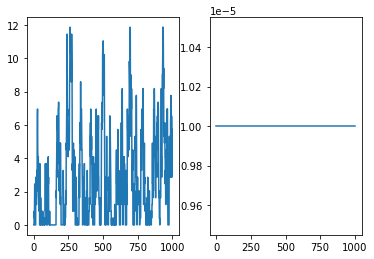

maximum steps, simulation is done ... 
elapsed_time: 51.979
Episode: 351 Exploration P: 0.0110 Total reward: -158.30143638825083 SOC: 0.4784 Cumulative_SOC_deviation: 52.2760 Fuel Consumption: 1.4735

maximum steps, simulation is done ... 
elapsed_time: 51.704
Episode: 352 Exploration P: 0.0110 Total reward: -205.92586994362614 SOC: 0.4874 Cumulative_SOC_deviation: 68.4913 Fuel Consumption: 0.4520

maximum steps, simulation is done ... 
elapsed_time: 52.081
Episode: 353 Exploration P: 0.0110 Total reward: -126.52255579633957 SOC: 0.5083 Cumulative_SOC_deviation: 41.5936 Fuel Consumption: 1.7418

maximum steps, simulation is done ... 
elapsed_time: 51.220
Episode: 354 Exploration P: 0.0110 Total reward: -196.75740308632666 SOC: 0.4707 Cumulative_SOC_deviation: 65.1909 Fuel Consumption: 1.1846

maximum steps, simulation is done ... 
elapsed_time: 51.296
Episode: 355 Exploration P: 0.0109 Total reward: -213.88568297867636 SOC: 0.4745 Cumulative_SOC_deviation: 70.8832 Fuel Consumption: 1.2

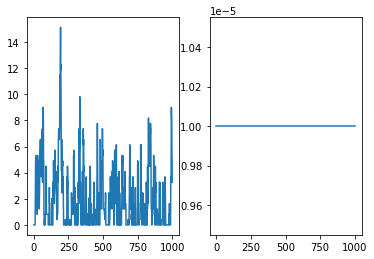

maximum steps, simulation is done ... 
elapsed_time: 51.996
Episode: 361 Exploration P: 0.0108 Total reward: -77.71776334598003 SOC: 0.5289 Cumulative_SOC_deviation: 25.2944 Fuel Consumption: 1.8347

maximum steps, simulation is done ... 
elapsed_time: 52.220
Episode: 362 Exploration P: 0.0108 Total reward: -131.70339935557783 SOC: 0.5294 Cumulative_SOC_deviation: 43.3412 Fuel Consumption: 1.6799

maximum steps, simulation is done ... 
elapsed_time: 51.635
Episode: 363 Exploration P: 0.0108 Total reward: -167.20710831587118 SOC: 0.4837 Cumulative_SOC_deviation: 55.5575 Fuel Consumption: 0.5346

maximum steps, simulation is done ... 
elapsed_time: 51.385
Episode: 364 Exploration P: 0.0108 Total reward: -382.0924021361408 SOC: 0.3039 Cumulative_SOC_deviation: 125.5110 Fuel Consumption: 5.5595

maximum steps, simulation is done ... 
elapsed_time: 51.110
Episode: 365 Exploration P: 0.0108 Total reward: -221.47571165894024 SOC: 0.4617 Cumulative_SOC_deviation: 73.1586 Fuel Consumption: 1.99

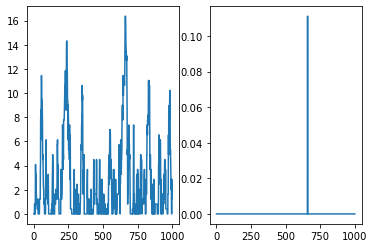

maximum steps, simulation is done ... 
elapsed_time: 51.886
Episode: 371 Exploration P: 0.0107 Total reward: -382.62671167129355 SOC: 0.2493 Cumulative_SOC_deviation: 125.4277 Fuel Consumption: 6.3437

maximum steps, simulation is done ... 
elapsed_time: 51.814
Episode: 372 Exploration P: 0.0107 Total reward: -308.3169323092445 SOC: 0.4447 Cumulative_SOC_deviation: 102.1332 Fuel Consumption: 1.9172

maximum steps, simulation is done ... 
elapsed_time: 51.852
Episode: 373 Exploration P: 0.0107 Total reward: -165.4884217749954 SOC: 0.4870 Cumulative_SOC_deviation: 54.6957 Fuel Consumption: 1.4013

maximum steps, simulation is done ... 
elapsed_time: 51.326
Episode: 374 Exploration P: 0.0106 Total reward: -53.706599130434896 SOC: 0.5193 Cumulative_SOC_deviation: 16.8229 Fuel Consumption: 3.2379

maximum steps, simulation is done ... 
elapsed_time: 51.283
Episode: 375 Exploration P: 0.0106 Total reward: -153.60987627241812 SOC: 0.4931 Cumulative_SOC_deviation: 50.5952 Fuel Consumption: 1.8

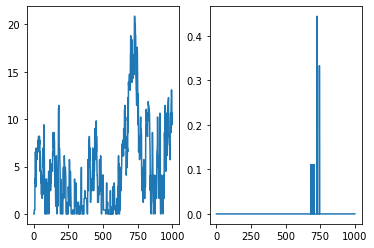

maximum steps, simulation is done ... 
elapsed_time: 51.878
Episode: 381 Exploration P: 0.0106 Total reward: -124.46353783633946 SOC: 0.5190 Cumulative_SOC_deviation: 41.1514 Fuel Consumption: 1.0092

maximum steps, simulation is done ... 
elapsed_time: 52.132
Episode: 382 Exploration P: 0.0105 Total reward: -240.28219648242018 SOC: 0.4555 Cumulative_SOC_deviation: 79.5341 Fuel Consumption: 1.6799

battery power is 109004.72814345021(+) but condition is not avail
elapsed_time: 18.598
Episode: 383 Exploration P: 0.0105 Total reward: -1272.1835961915453 SOC: 0.0640 Cumulative_SOC_deviation: 82.2001 Fuel Consumption: 27.1913

maximum steps, simulation is done ... 
elapsed_time: 51.807
Episode: 384 Exploration P: 0.0105 Total reward: -211.06611212919492 SOC: 0.4371 Cumulative_SOC_deviation: 70.0534 Fuel Consumption: 0.9060

maximum steps, simulation is done ... 
elapsed_time: 51.187
Episode: 385 Exploration P: 0.0105 Total reward: -142.15938349859366 SOC: 0.5034 Cumulative_SOC_deviation: 4

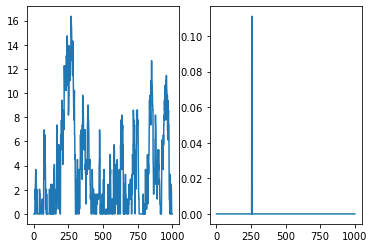

maximum steps, simulation is done ... 
elapsed_time: 51.838
Episode: 391 Exploration P: 0.0105 Total reward: -194.73106322911596 SOC: 0.4614 Cumulative_SOC_deviation: 64.4020 Fuel Consumption: 1.5251

maximum steps, simulation is done ... 
elapsed_time: 52.172
Episode: 392 Exploration P: 0.0105 Total reward: -139.8578133257368 SOC: 0.5135 Cumulative_SOC_deviation: 46.1315 Fuel Consumption: 1.4632

maximum steps, simulation is done ... 
elapsed_time: 51.987
Episode: 393 Exploration P: 0.0104 Total reward: -572.7080772622886 SOC: 0.2949 Cumulative_SOC_deviation: 188.7503 Fuel Consumption: 6.4572

maximum steps, simulation is done ... 
elapsed_time: 52.172
Episode: 394 Exploration P: 0.0104 Total reward: -204.96424462716314 SOC: 0.4201 Cumulative_SOC_deviation: 67.6067 Fuel Consumption: 2.1442

maximum steps, simulation is done ... 
elapsed_time: 51.377
Episode: 395 Exploration P: 0.0104 Total reward: -486.44873793063755 SOC: 0.1819 Cumulative_SOC_deviation: 159.4331 Fuel Consumption: 8.1

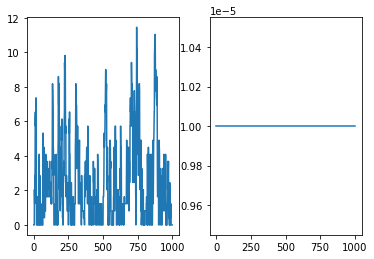

model is saved..


In [15]:
# print(env.version)

# num_trials = 1
reward_factors = [1, 2, 3]
results_dict = {} 

for reward_factor in reward_factors: 
    print("")
    print("Trial {}".format(reward_factor))
    print("")
    
    actor_model, critic_model, target_actor, target_critic, buffer = initialization()
    
    eps = MAX_EPSILON 
    steps = 0
    
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    episode_test_history = [] 
    episode_num_test = [] 
    for ep in range(total_episodes): 
        
        driving_cycle = driver.get_cycle() 
        env = initialization_env(driving_cycle, reward_factor)
        
        start = time.time() 
        state = env.reset() 
        episodic_reward = 0 

        while True: 
            tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = policy_epsilon_greedy(tf_state, eps)
    #         print(action)
            next_state, reward, done = env.step(action)
            if done: 
                next_state = [0] * num_states 

            buffer.record((state, action, reward, next_state))
            episodic_reward += reward 

            if steps > DELAY_TRAINING: 
                buffer.learn() 
                update_target(tau)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * (steps
                                                                        -DELAY_TRAINING))

            steps += 1

            if done: 
                break 

            state = next_state 

        elapsed_time = time.time() - start 
        print("elapsed_time: {:.3f}".format(elapsed_time))
        episode_rewards.append(episodic_reward) 
        episode_SOCs.append(env.SOC)
        episode_FCs.append(env.fuel_consumption) 

    #     print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
        print(
              'Episode: {}'.format(ep + 1),
              "Exploration P: {:.4f}".format(eps),
              'Total reward: {}'.format(episodic_reward), 
              "SOC: {:.4f}".format(env.SOC), 
              "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
              "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
        )
        print("")
        
        if (ep + 1) % 10 == 0: 
            history = test_agent(actor_model, reward_factor)
            episode_test_history.append(history) 
            episode_num_test.append(ep + 1)
            
#         if (ep + 1) % 200 == 0:             
    root = "DDPG_MDP_reward_factor{}".format(reward_factor)
    save_weights(actor_model, critic_model, target_actor, target_critic, root)
            
    
    results_dict[reward_factor] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs, 
        "test_history": episode_test_history, 
        "test_episode_num": episode_num_test, 
    }

In [16]:
with open("DDPG_MDP_1to3.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [17]:
# results_dict